In [1]:
import sys
import matplotlib.pyplot as plt
import torch

sys.path.append('..')

from cnsproject.network.connections import DenseConnection
from cnsproject.network.neural_populations import (LIFPopulation,
                                                   InputPopulation)
from cnsproject.network.network import Network
from cnsproject.learning.learning_rules import STDP
from cnsproject.encoding.encoders import PoissonEncoder
from cnsproject.plotting.plotting import raster_plot
from cnsproject.network.monitors import Monitor

%matplotlib inline

In [2]:
def run_stdp(**kwargs) -> (int, Network):
    random_seed: int = kwargs.get("random_seed", None)
    is_flat: bool = kwargs.get("is_flat", False)
    sim_time: int = kwargs.get("sim_time", 25000)
    n_pre_neurons: int = kwargs.get("n_pre_neurons", 6)
    tau_s: float = kwargs.get("tau_s", 10.)
    post_threshold: float = kwargs.get("threshold", -52.)
    lr: list = kwargs.get("lr", [0.03] * 2)
    j0: float = kwargs.get('j0', 11.)
    sig0: float = kwargs.get('sig0', 2.5)
    w_max: float = kwargs.get('w_max', 7.5)
    input_intensity: float = kwargs.get("input_intensity", 500.)
    repeat_times: int = kwargs.get("repeat_times", 5)
    figsize: tuple = kwargs.get("figsize", (13, 17))
    fig_title: str = kwargs.get("fig_title", "Results")
    do_exp_decay: bool = kwargs.get("do_exp_decay", True)
    draw_plots: bool = kwargs.get("draw_plots", True)
    train_ratio: float = kwargs.get("train_ratio", 0.6)
    draw_input_plot: bool = kwargs.get("draw_input_plot", True)
    monitor_traces: bool = kwargs.get("monitor_traces", False)

    if not draw_input_plot:
        figsize = (figsize[0], figsize[1] * 0.75)

    if random_seed is not None:
        torch.random.manual_seed(random_seed)
        torch.manual_seed(random_seed)
    else:
        random_seed = torch.random.seed()
    in_pop = InputPopulation((n_pre_neurons,), tau_s=tau_s,
                             do_exp_decay=do_exp_decay)
    out_pop = LIFPopulation((2,), threshold=post_threshold, tau_s=tau_s,
                            do_exp_decay=do_exp_decay, is_inhibitory=True)
    in_out_connection = DenseConnection(
        in_pop, out_pop,
        learning_rule=STDP, lr=lr, is_flat=is_flat,
        sig0=sig0, j0=j0, wmax=w_max, wmin=0.
    )
    out_connection = DenseConnection(
        out_pop, out_pop,
        j0=j0 / 6, wmax=w_max / 2, wmin=0.
    )

    monitor_vars = ['w']
    monitor = Monitor(in_out_connection, state_variables=monitor_vars)
    monitor_out = Monitor(out_pop, state_variables=["s", "traces"])
    monitor_in = Monitor(in_pop, state_variables=["s", "traces"])
    monitor.set_time_steps(sim_time, 1.)
    monitor.reset_state_variables()
    monitor_out.set_time_steps(sim_time, 1.)
    monitor_out.reset_state_variables()
    monitor_in.set_time_steps(sim_time, 1.)
    monitor_in.reset_state_variables()

    if repeat_times is None:
        encoder = PoissonEncoder(sim_time // 2, rate_max=sim_time // 100)
    elif repeat_times == 5:
        encoder = PoissonEncoder(sim_time // 10, rate_max=sim_time // 500)
    elif repeat_times == 2:
        encoder = PoissonEncoder(sim_time // 4, rate_max=sim_time // 200)
    elif repeat_times == 4:
        encoder = PoissonEncoder(sim_time // 8, rate_max=sim_time // 400)
    elif repeat_times == 10:
        encoder = PoissonEncoder(sim_time // 20, rate_max=sim_time // 1000)
    else:
        raise NotImplementedError('repeat_times is not implemented!')

    n_half = (n_pre_neurons // 2)
    x = torch.tensor([0.01] * n_half + [0.99] * n_half)
    y = torch.tensor([0.99] * n_half + [0.01] * n_half)
    x = encoder(x * input_intensity)
    y = encoder(y * input_intensity)
    x[:int(len(x) * 7.5 / 100)] = 0
    x[int(-len(x) * 7.5 / 100):] = 0
    y[:int(len(y) * 7.5 / 100)] = 0
    y[int(-len(y) * 7.5 / 100):] = 0
    data = torch.vstack((y, x))
    if repeat_times is not None:
        if repeat_times == 5:
            data = torch.vstack((data, data, data, data, data))
        elif repeat_times == 2:
            data = torch.vstack((data, data))
        elif repeat_times == 4:
            data = torch.vstack((data, data, data, data))
        elif repeat_times == 10:
            data = torch.vstack((data, data, data, data, data))
            data = torch.vstack((data, data))
        else:
            raise NotImplementedError('repeat_times is not implemented!')

    encoder = PoissonEncoder(sim_time, sim_time // 100)
    z = torch.tensor([0.45, 0.45] * n_half)
    z = encoder(z * input_intensity)
    out_pop_currents = torch.zeros(sim_time, *out_pop.shape)
    test_inputs = dict(in_pop=z, out_pop=out_pop_currents)
    input_dict = dict(in_pop=data, out_pop=out_pop_currents)

    net = Network(learning=True, train_ratio=train_ratio)
    net.add_layer(in_pop, "in_pop")
    net.add_layer(out_pop, "out_pop")
    net.add_connection(in_out_connection, "in_pop", "out_pop")
    net.add_connection(out_connection, "out_pop", "out_pop")
    net.add_monitor(monitor, "connection")
    net.add_monitor(monitor_out, "monitor_out")
    if draw_input_plot:
        net.add_monitor(monitor_in, "monitor_in")
    if monitor_traces:
        monitor_learning = Monitor(in_out_connection.learning_rule,
                           state_variables=["post_traces", "pre_traces"])
        net.add_monitor(monitor_learning, "monitor_learning")

    net.run(sim_time=sim_time, current_inputs=input_dict,
            test_inputs=test_inputs)

    p_s = 0 if draw_input_plot else -1
    if draw_plots:
        if draw_input_plot:
            fig, ax = plt.subplots(4, figsize=figsize)
        else:
            fig, ax = plt.subplots(3, figsize=figsize)
        fig.suptitle(fig_title)
        weights = net.monitors["connection"].get('w')
        if draw_input_plot:
            raster_plot(net.monitors["monitor_in"], y_offset=0,
                        y_label=False, ax=ax[0], legend=False, set_xlim=False,
                        title="Input Neurons Raster Plot (Encoded Data)")
        raster_plot(net.monitors["monitor_out"], y_offset=0,
                    y_label=False, ax=ax[1 + p_s], legend=False,
                    set_xlim=False,
                    title="Output Neurons Raster Plot")
        for i in range(n_pre_neurons):
            ax[2 + p_s].plot(weights[:, i, 1], label='$w_{}$'.format(i))
            ax[3 + p_s].plot(weights[:, i, 0], label='$w_{}$'.format(i))

        if train_ratio is not None:
            for i in range(len(ax)):
                ax[i].axvline(x=int(sim_time * train_ratio),
                              linestyle='--', linewidth=1,
                              c="r", label="Train Stop")
                ax[i].axvline(x=int(sim_time * (1 + train_ratio) / 2),
                              linestyle='--', linewidth=1,
                              c="y", label="Test Start")
        if draw_input_plot:
            ax[0].set_yticks(torch.arange(n_pre_neurons))
        ax[1 + p_s].set_ylim(bottom=-0.5)
        ax[1 + p_s].set_yticks([0, 1])
        ax[2 + p_s].title.set_text('Output-Neuron-1 Weights')
        ax[3 + p_s].title.set_text('Output-Neuron-0 Weights')
        ax[3 + p_s].set_xlabel("Time(ms)")
        for i in range(len(ax)):
            ax[i].legend(loc="upper right")
        fig.tight_layout(rect=[0, 0.03, 1, 0.99])
        plt.show()

    return random_seed, net

# Introduction

## Pair-based STDP

We implement the following rule for $STDP$:

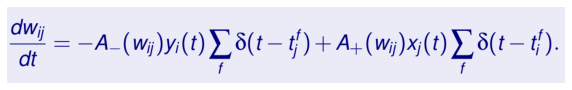

In [3]:
def show_image(filename: str, figsize):
    img = plt.imread(filename)
    _, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(img)
    ax.axis('off')
    plt.show()

show_image('images/stdp.png', (10, 5))

$y_i$ and $x_j$ are spike traces and are determined like this:

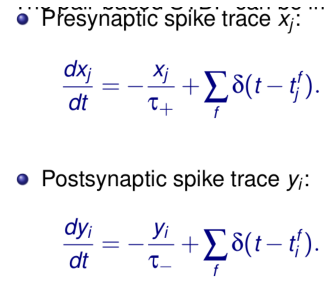

In [4]:
show_image('images/traces.png', (10, 5))

Using the update rule results in the following pattern in the weights:

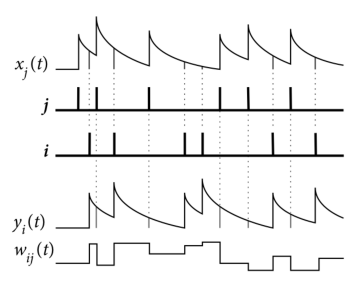

In [5]:
show_image('images/weights.png', (10, 5))

To make the output neurons better distinguish the inputs and make each of them
learn only one of the input patterns, we also added a lateral-inhibition in the
output layer. The weights of this inhibitory connection is fixed with random
initialization.

## Input

The input patterns are created by using the PoissonEncoder that we implemented
in the previous project.
You can see the patterns below:

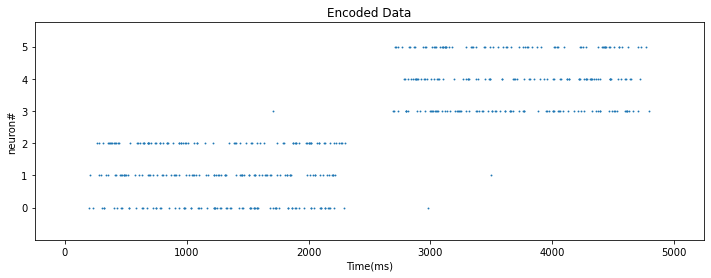

In [6]:
seed = 6626393261193957152
_, network = run_stdp(draw_plots=False, random_seed=seed, repeat_times=None,
                      sim_time=5000, train_ratio=None)
raster_plot(network.monitors["monitor_in"], y_offset=0,
            legend=False, set_xlim=False, figsize=(12, 4),
            title="Encoded Data")
plt.yticks(torch.arange(network.layers["in_pop"].shape[0]))
plt.xlabel("Time(ms)")
plt.show()

By default, the input patterns will be presented to the network four
 times in our experiments. The last time the training is stopped to check whether
 the network has learned the patterns correctly. Finally, a random pattern
 whose average intensity is almost the same as the patterns is fed into the network.
 This last input is used to show that the network does not activate
 significantly with an input that it has not seen previously.
 We call the first three iterations, training iterations, and the 4th step,
 the evaluation iteration. The last step is the testing iteration.
So, the complete input is as follows:

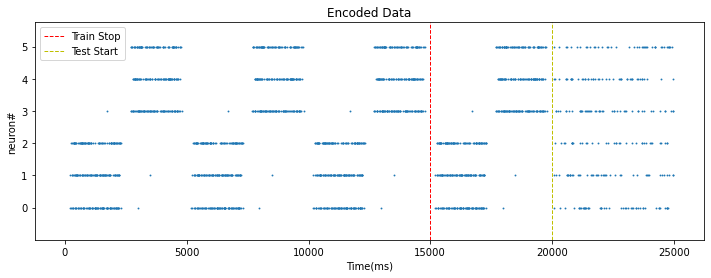

In [7]:
sim_time = 25000
_, network = run_stdp(draw_plots=False, repeat_times=5, random_seed=seed,
                      train_ratio=0.6, sim_time=sim_time)
fig, ax = plt.subplots(1, figsize=(12, 4))
raster_plot(network.monitors["monitor_in"], ax=ax, y_offset=0,
            legend=False, set_xlim=False,
            title="Encoded Data")
ax.axvline(x=sim_time * 0.6,
           linestyle='--', linewidth=1,
           c="r", label="Train Stop")
ax.axvline(x=sim_time * (1 + 0.6) / 2,
           linestyle='--', linewidth=1,
           c="y", label="Test Start")
ax.set_xlabel("Time(ms)")
ax.set_yticks(torch.arange(network.layers["in_pop"].shape[0]))
ax.legend(loc="upper left")
plt.show()

Note that the PoissonEncoder is working **randomly**, so the inputs are
a bit different from one simulation to the other. The connection weights
are also **randomly** drawn from a normal distribution. To keep the comparisons fair, we fix the **random-seed** when investigating the
effect of each parameter in order to have exactly the same input for each case.

By running the training process numerous times, we found a couple of **good**
random seeds that make the network show the correct output of the learning rules.
We use these good seeds for the following experiments.

## How do we know the network is learning the data?

The co-variance of the input patterns and output neurons' activations indicate
that the learning is happening. In other words, the first time the network sees
the input, the output activation is low; if the data is presented to the network
for more iterations, each time the activation of the neurons tend to increase.
This means that the network is learning the input pattern because its activation
is increasing each time that it sees the exact same data.
In our experiments, we interpret the dependency between the network output and
input visually using the output neurons' raster plot.

# STDP

## Default Parameters:


**Train Params:**

$\qquad Time_{simulation} = 25000ms \\$
$\qquad LearningRates = [0.03, 0.03]$ →The first learning-rate refers to $A_-$, and the second learning-rate refers to $A_+$.

$\\$

**Neurons Params:**

$\qquad Num(PresynapticNeurons) = 6$

$\qquad \tau_s=10ms$

$\qquad Threshold=-52mv$

$\qquad U_{rest}=-60mv$

$\\$

**Connection Params:**

$\qquad J_0 = 11$

$\qquad \sigma_0 = 2.5$

$\qquad Weight_{min} = 0$

$\qquad Weight_{max} = 7.5$

## Experiment #1 (Initial Weights)

### $J_0$

Higher values of $J_0$ indicate higher initial weights for connections' weights.

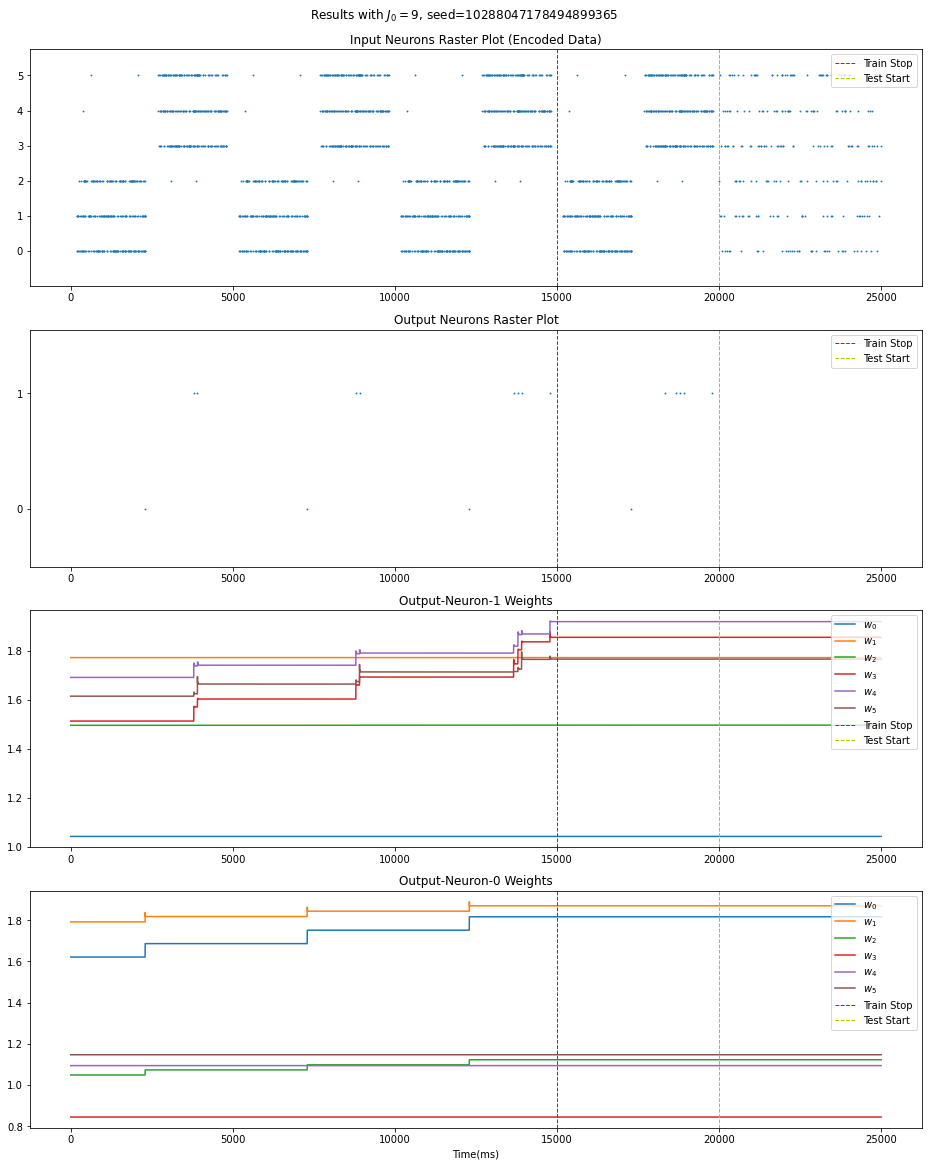

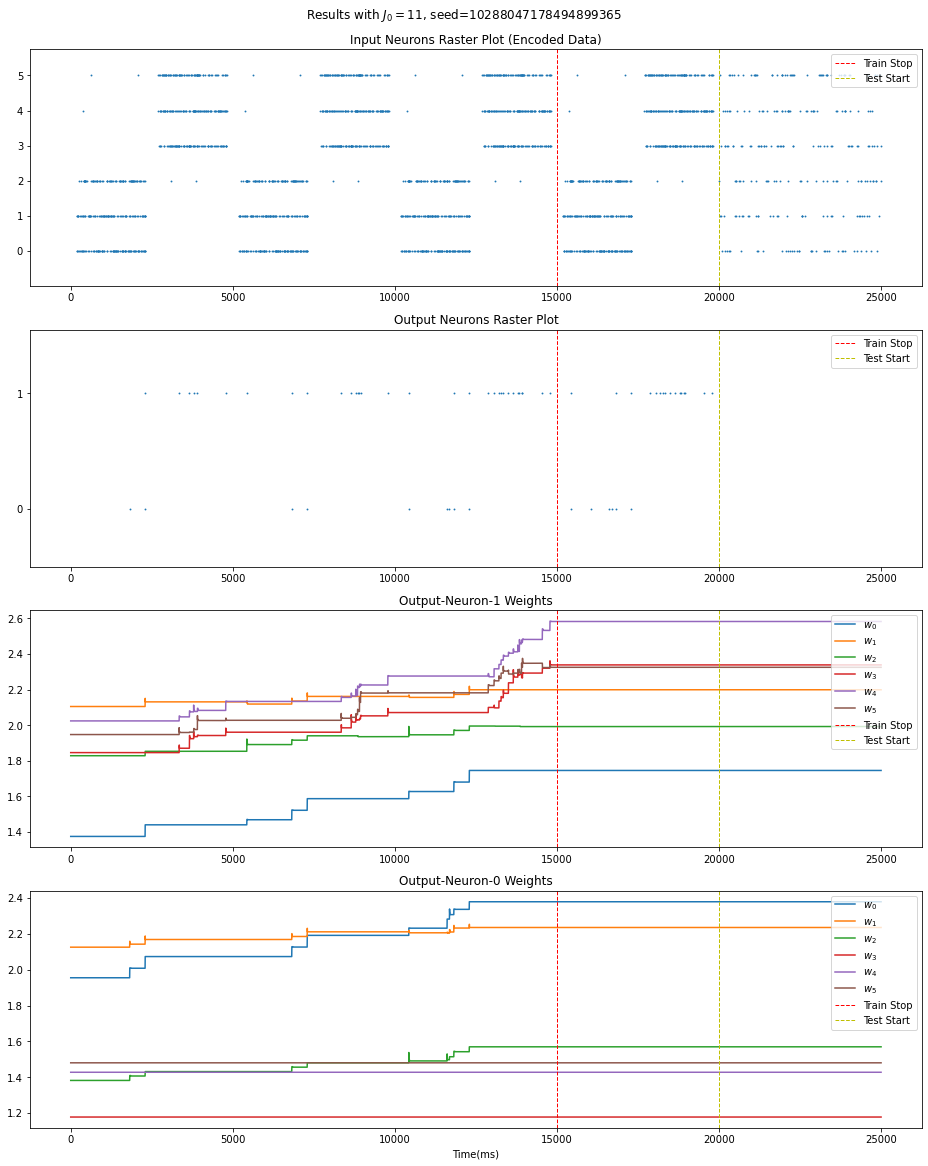

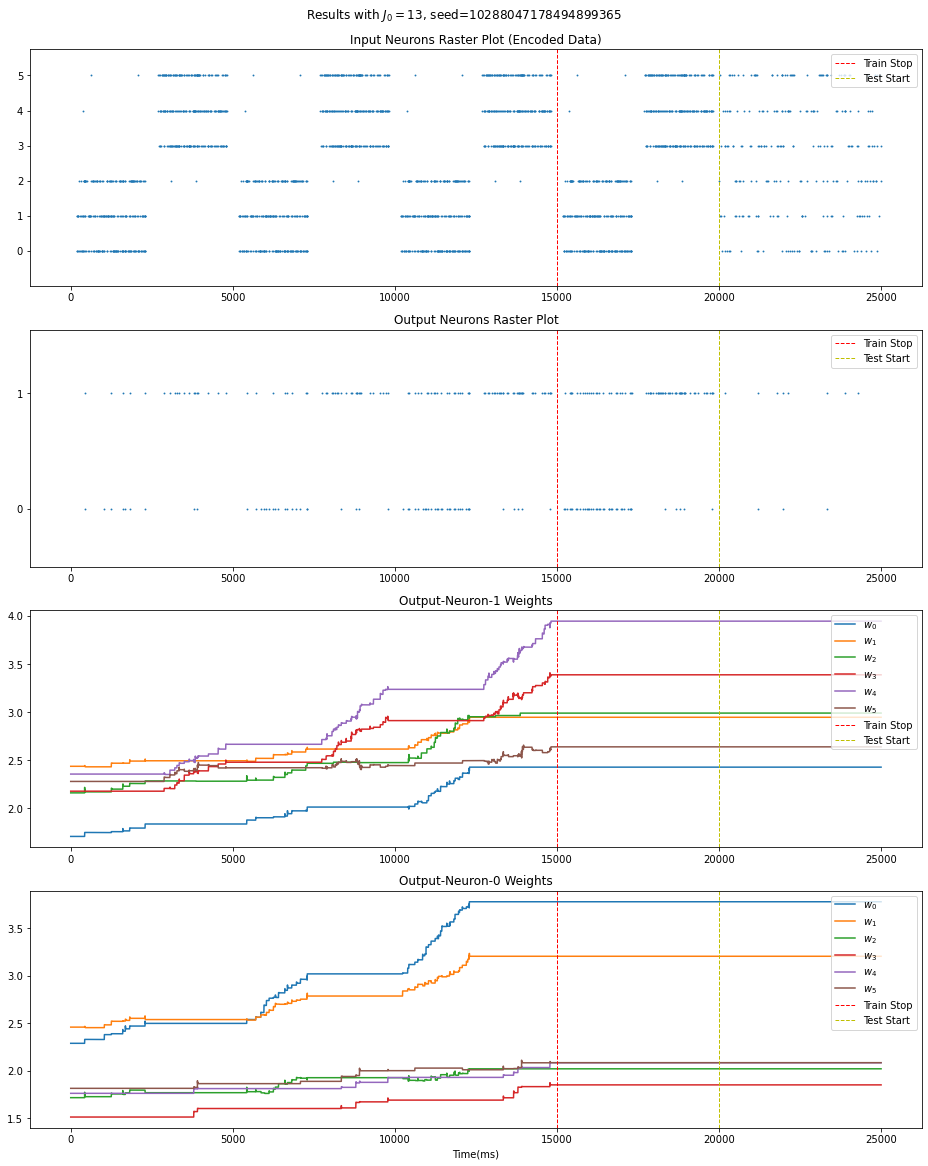

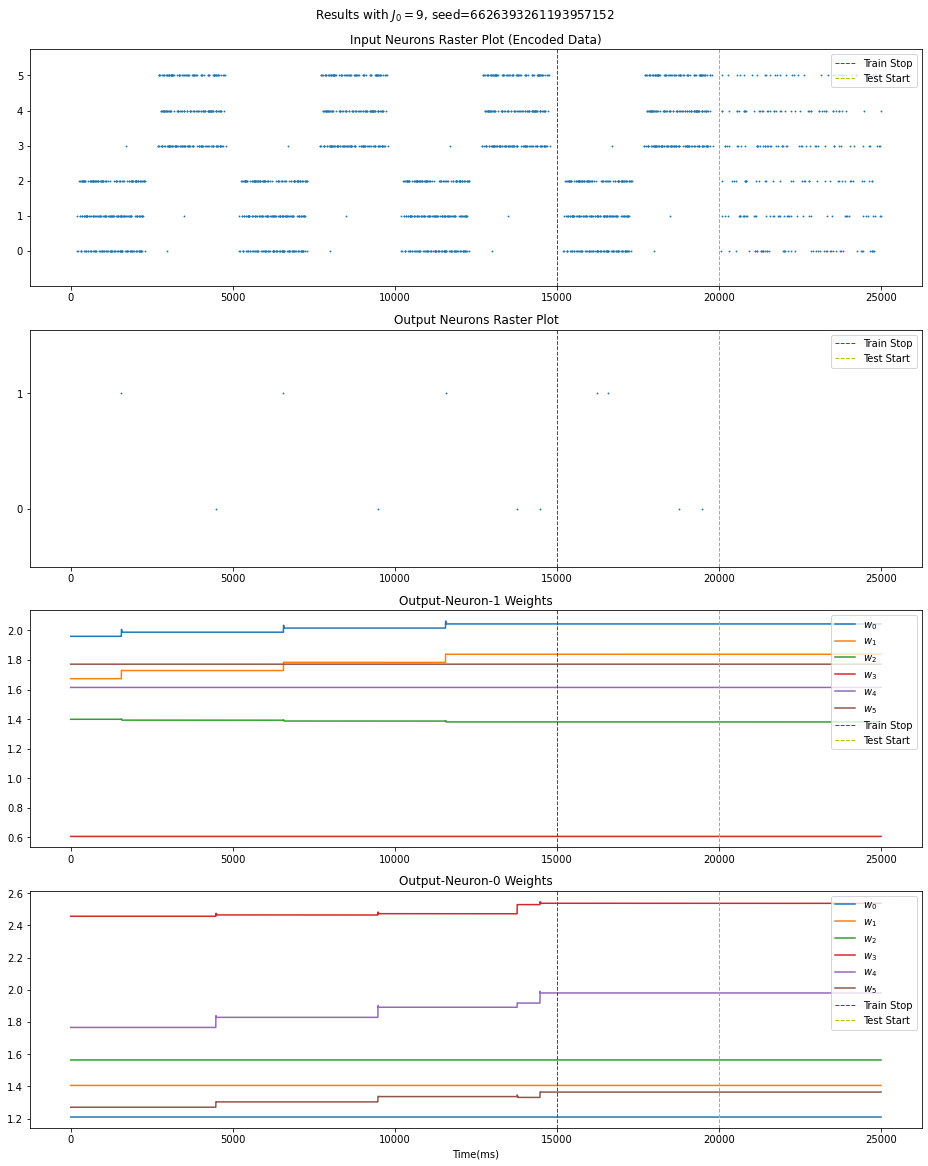

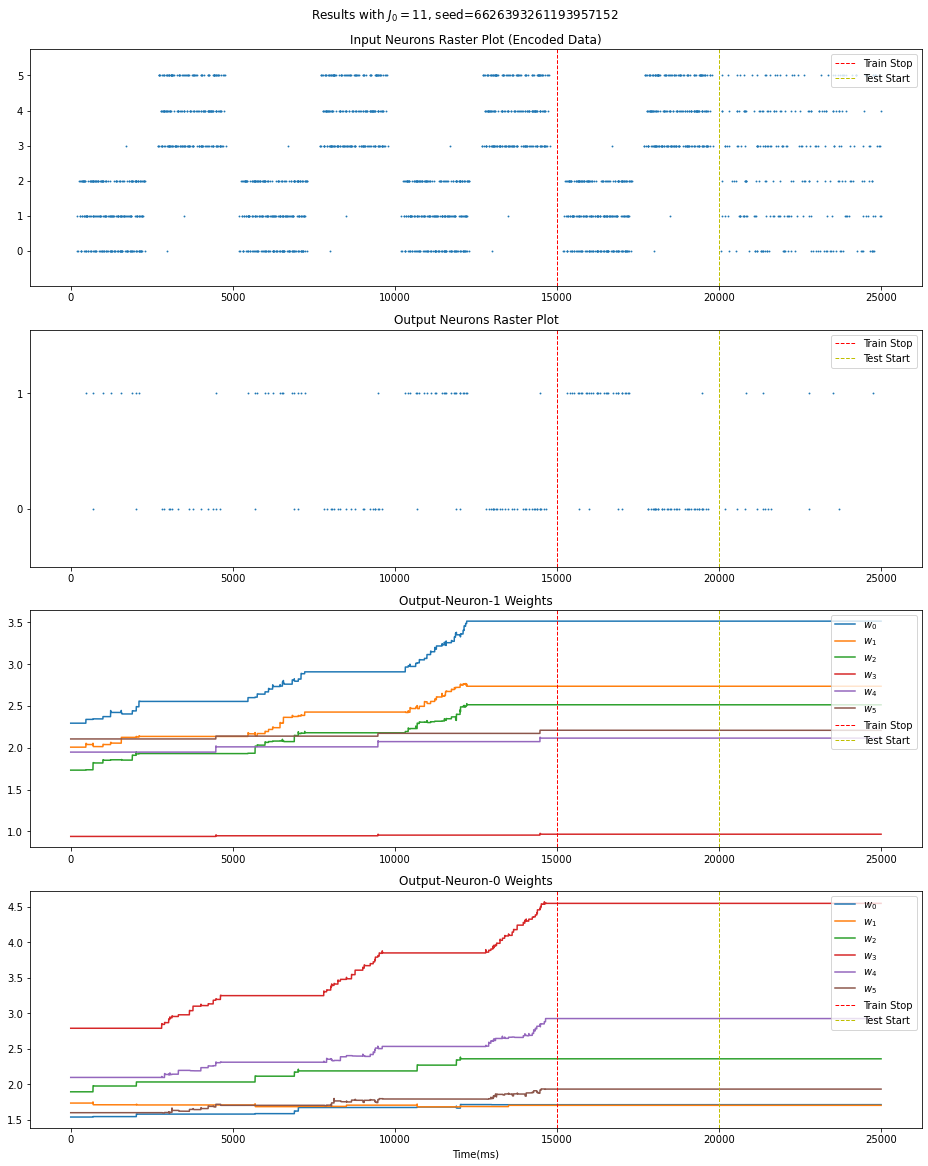

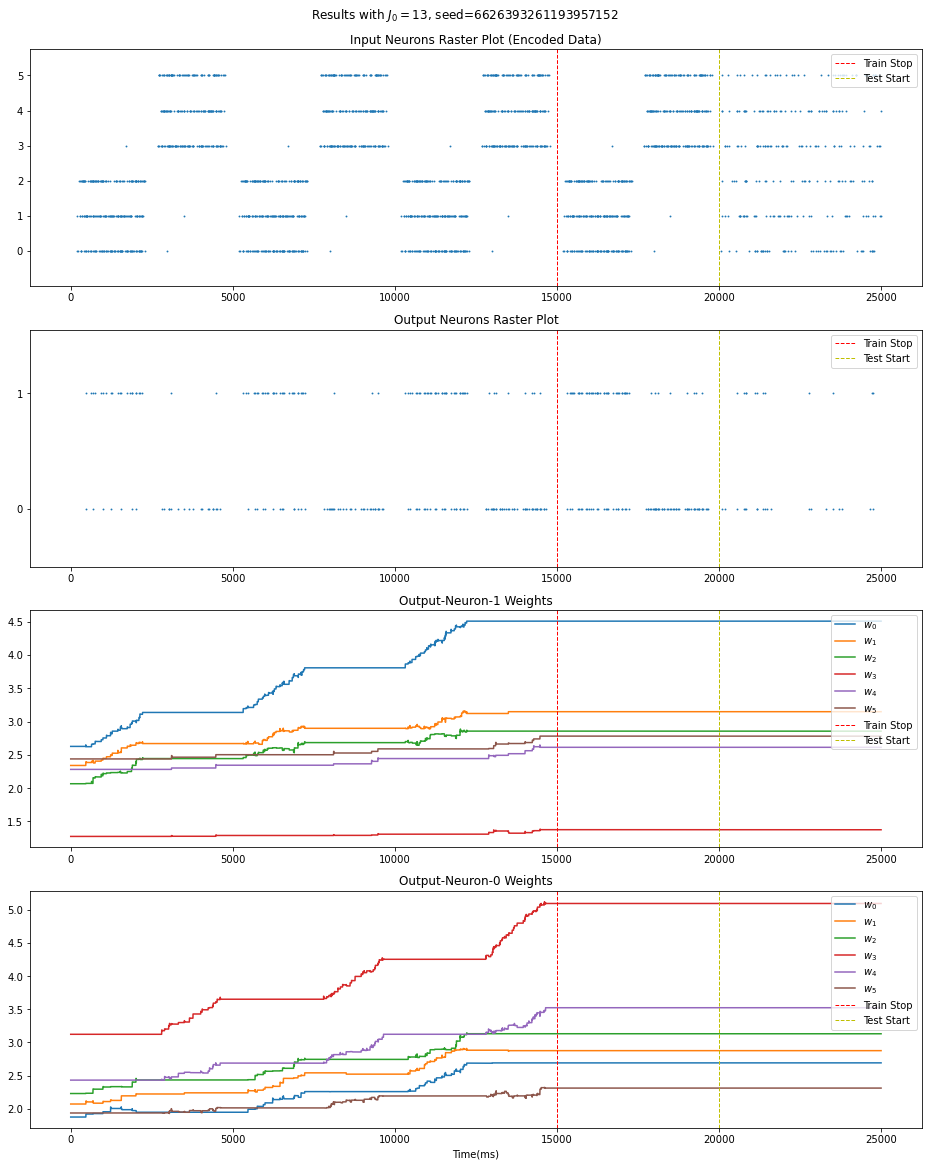

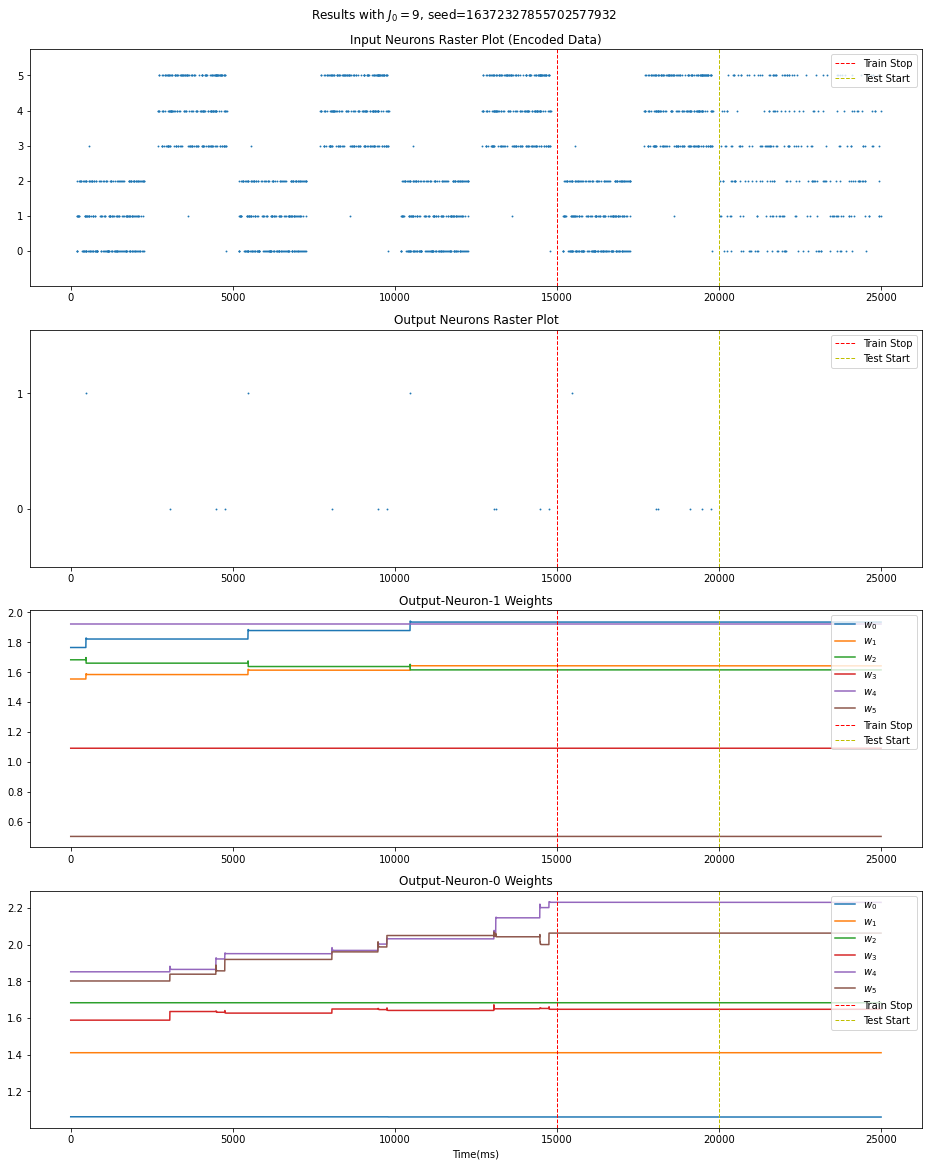

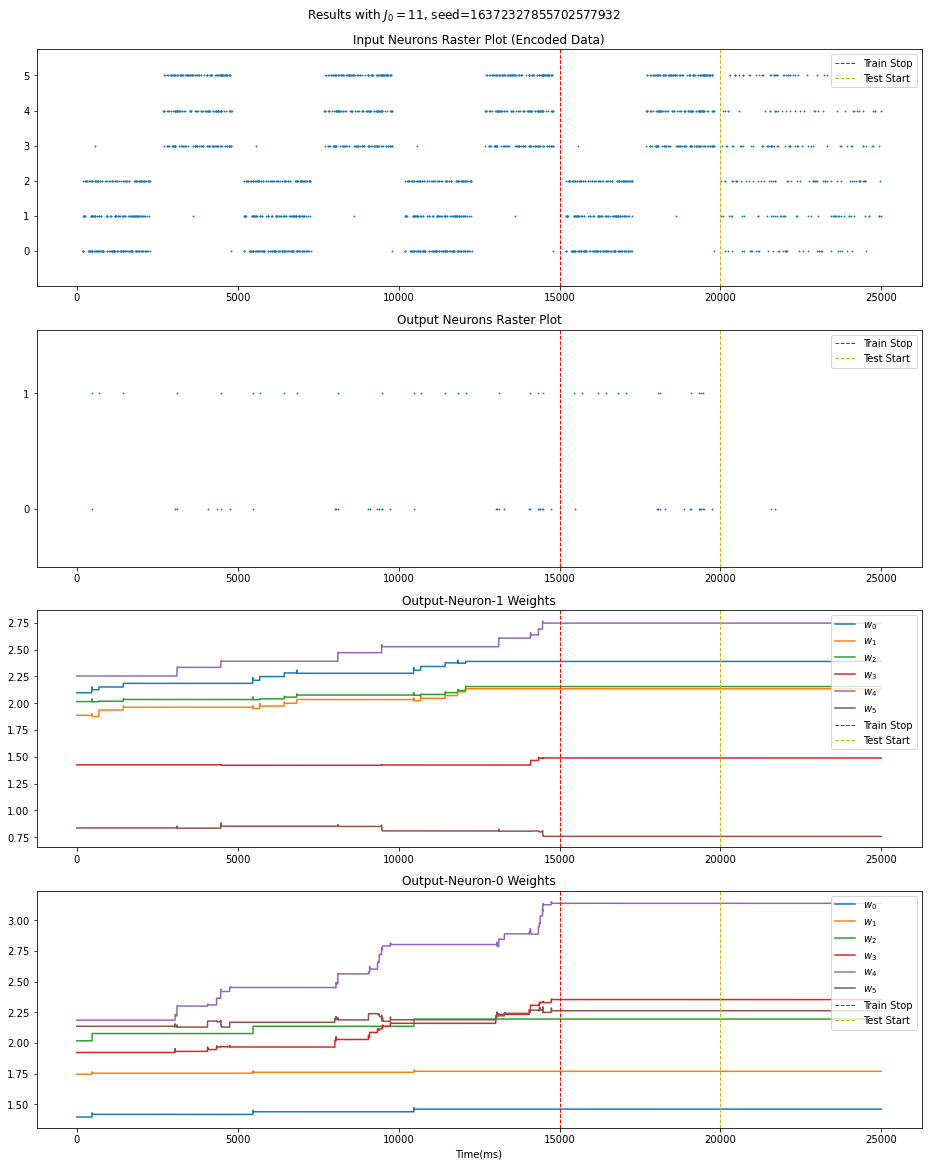

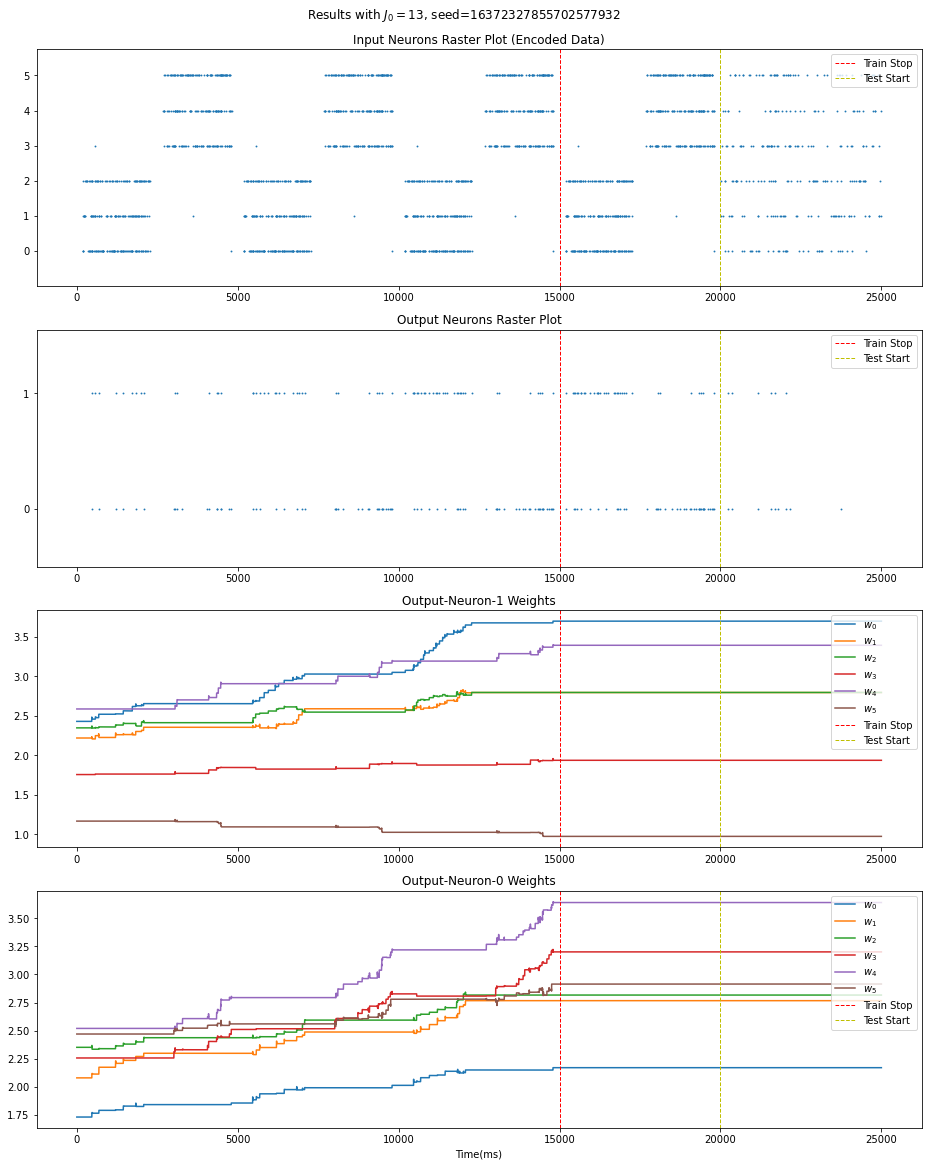

In [8]:
j0s = [9, 11, 13]
seeds = [10288047178494899365, 6626393261193957152, 16372327855702577932]
for seed in seeds:
    for j0 in j0s:
        run_stdp(j0=j0, fig_title=f"Results with $J_0 = {j0}$, seed={seed}",
                 random_seed=seed)

From the above plots we conclude the following:

1. If the initial weights are too low (all less than 2),
the network activation will be too low
to let the training process start. This is due to the fact that STDP is based
on neurons' activations; so, without any activation the training process cannot
happen, and the network will not **learn** the input patterns.

2. If the initial weights are too high,
the network initial activation is too high; therefore, the connections' weights
tend to increase with any input not specifically with the patterns. In other words,
high initial weights have a bad effect on network's sensitivity on the input patterns.
Also, the network activity tends to increase with unseen data when value of $J_0$
is high.

3. When we set $J_0 = 11$, the learning process is perfectly visible in the
network's output pattern. With the second random seed, the first neuron is
learning the second pattern, and the second neuron is learning the first input pattern.
With the first random seed, the second neuron is learning both patterns, but with
more concentration on the second pattern. The first neuron is slowly learning
the first pattern only.

## Experiment #2 (Learning Rate)

### Equal Learning Rates

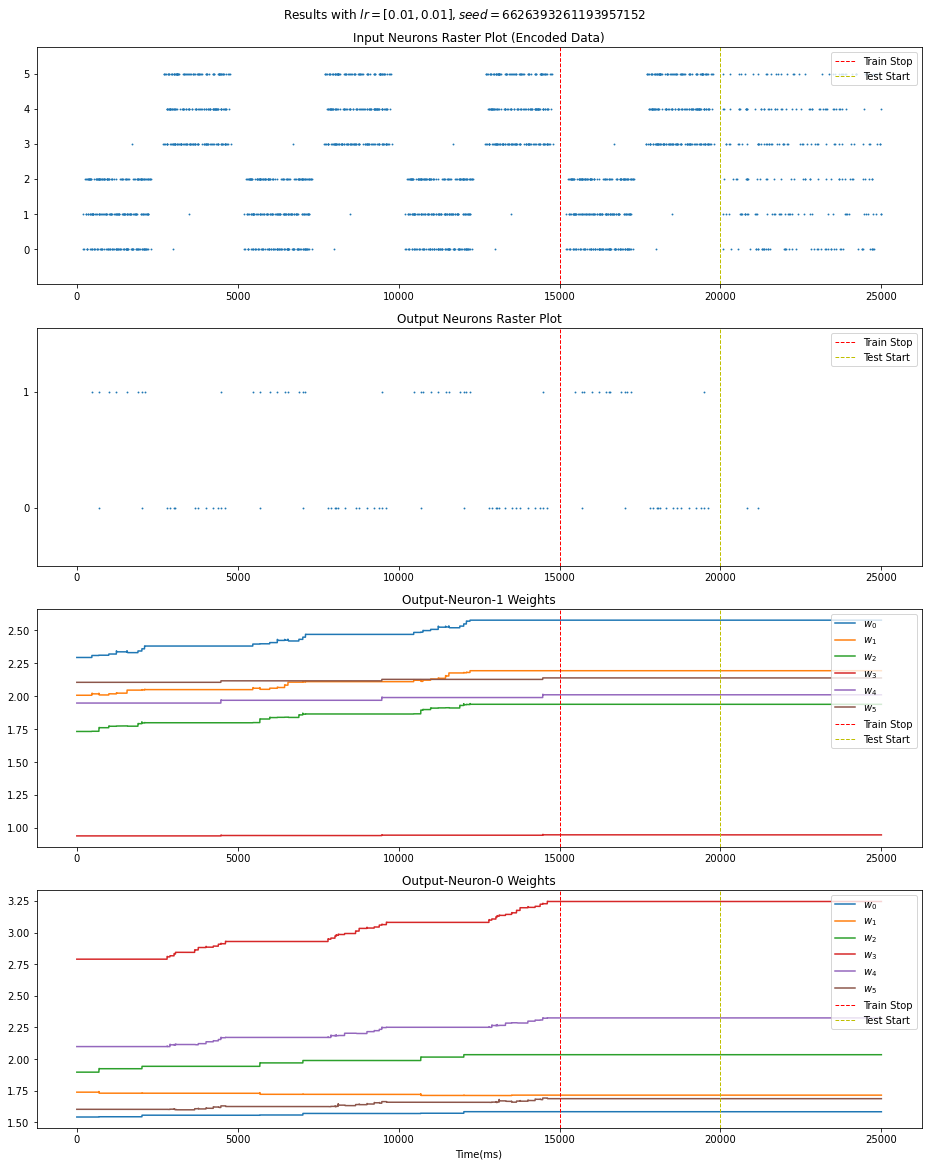

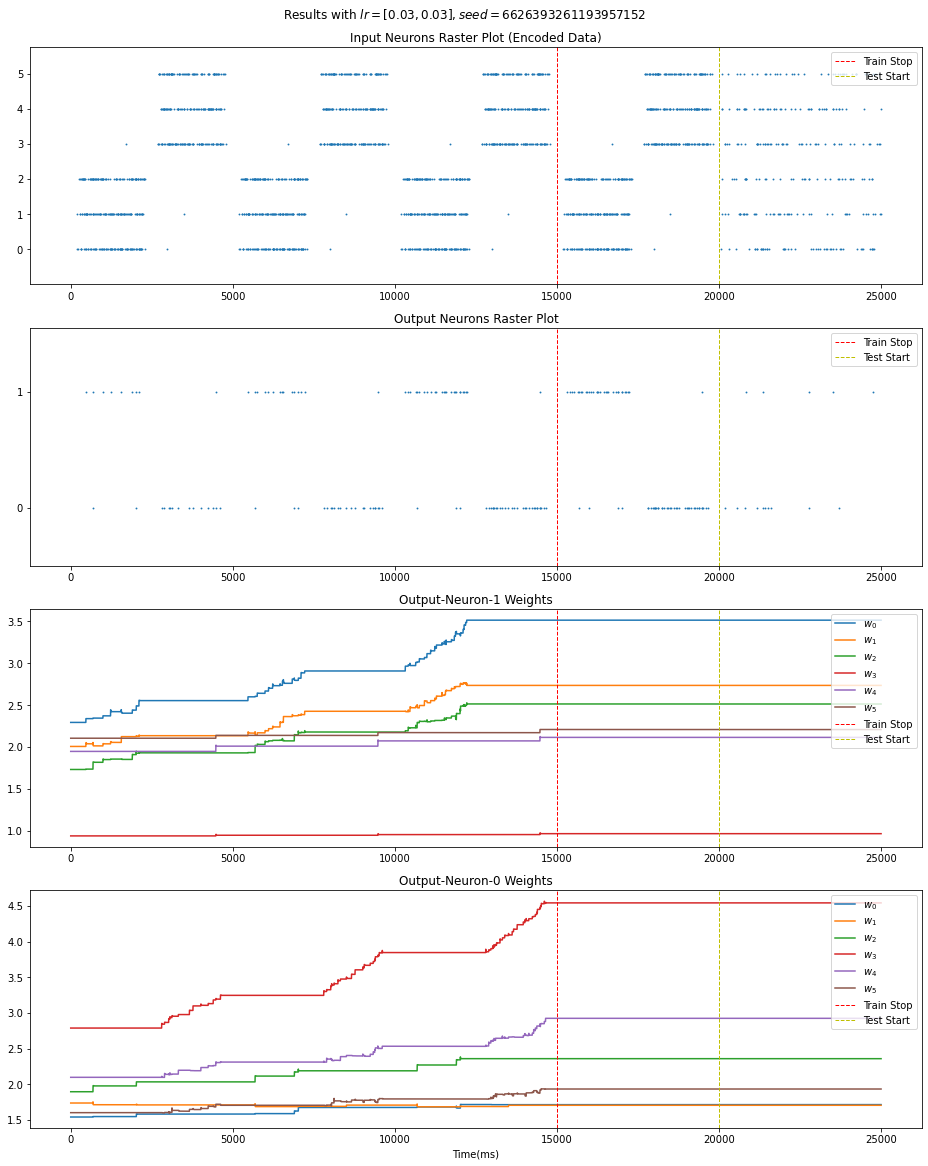

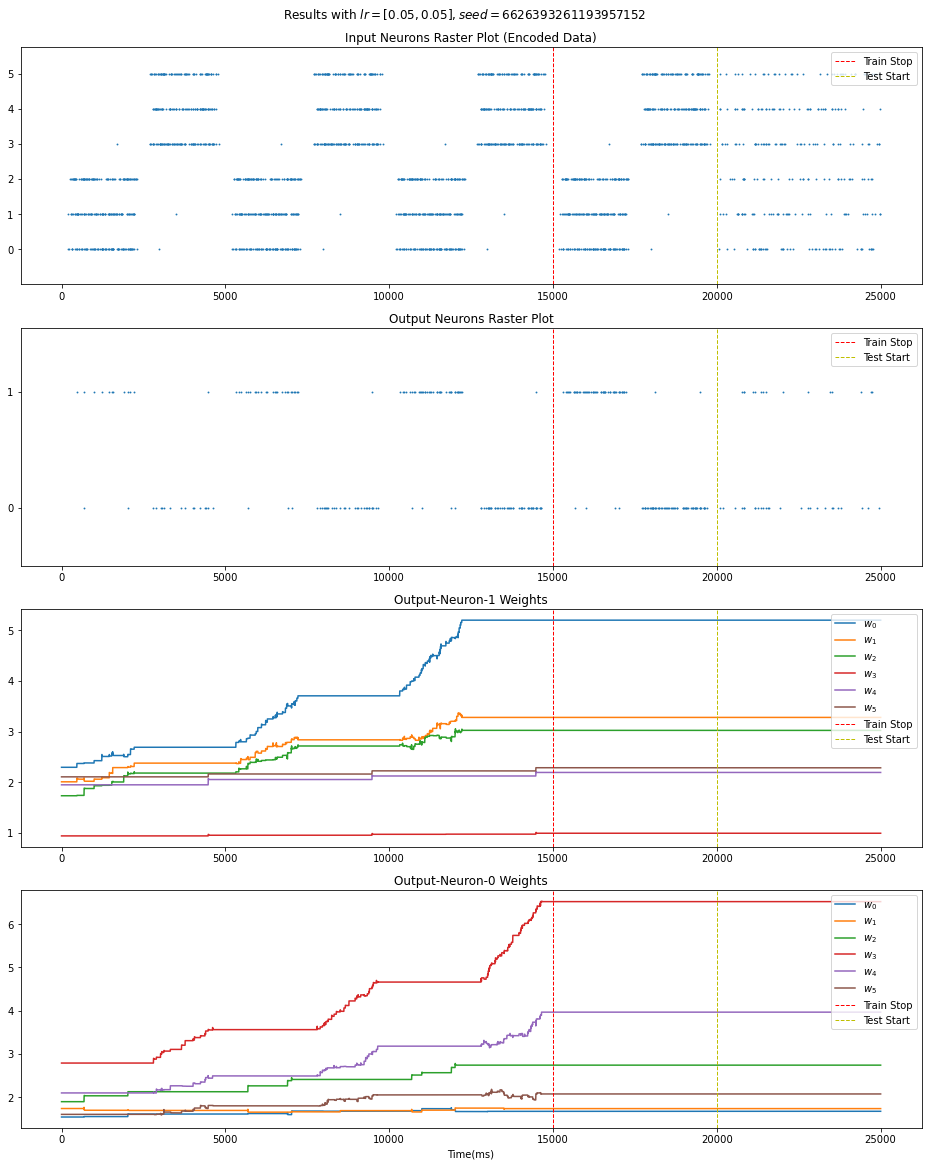

In [9]:
seed = 6626393261193957152
learning_rates = [0.01, 0.03, 0.05]
for lr in learning_rates:
    run_stdp(lr=[lr] * 2, fig_title=f"Results with $lr = {[lr, lr]}, "
                                    f"seed={seed}$",
             random_seed=seed)

As expected, the higher the learning-rates, the faster the training occurs.
The learning rate could be seen in the slope of weights' plots. By increasing
the learning rates, the slope of weight-plots tend to increase.

### Unequal Learning Rates

In this case, to make the results more visible
we only demonstrate extreme inequality between learning rates.

The first plot is drawn to have a baseline for comparison.

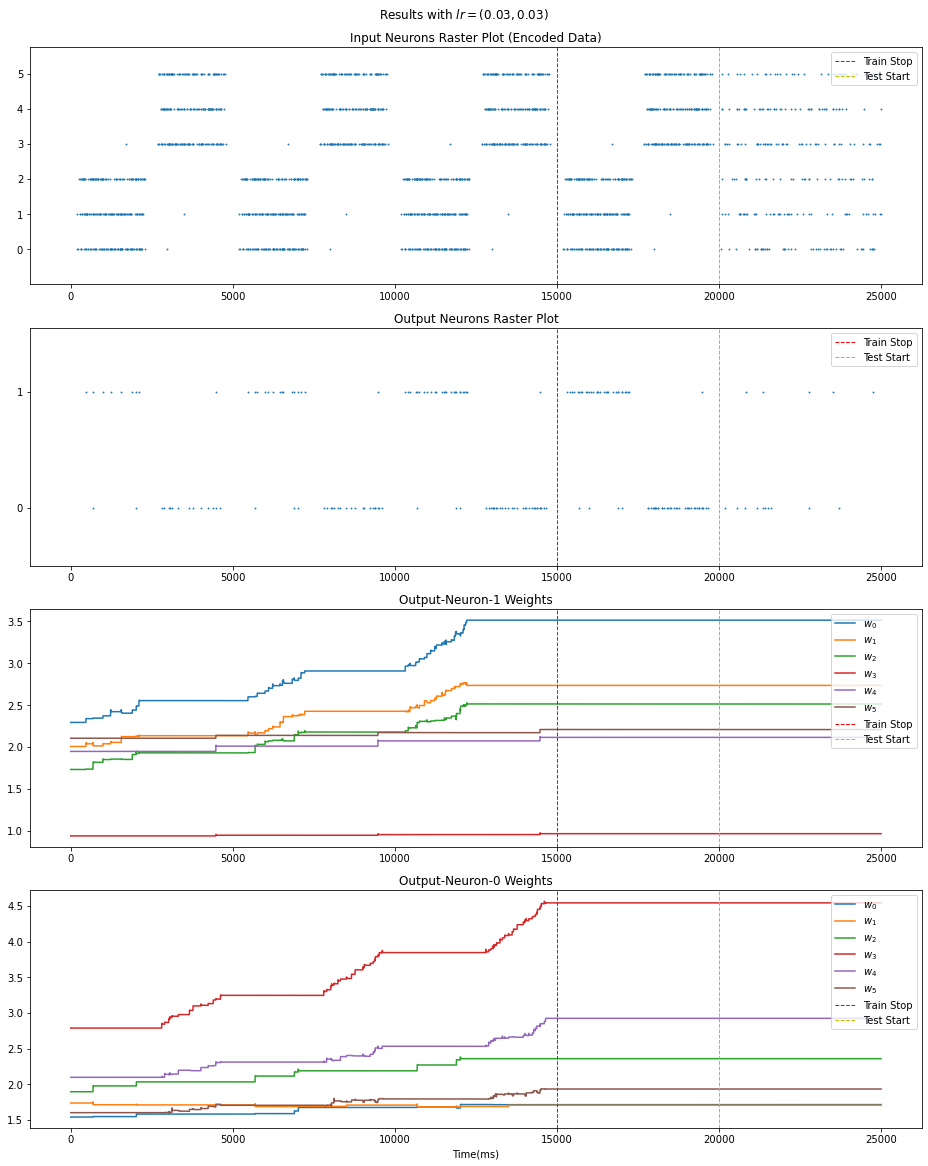

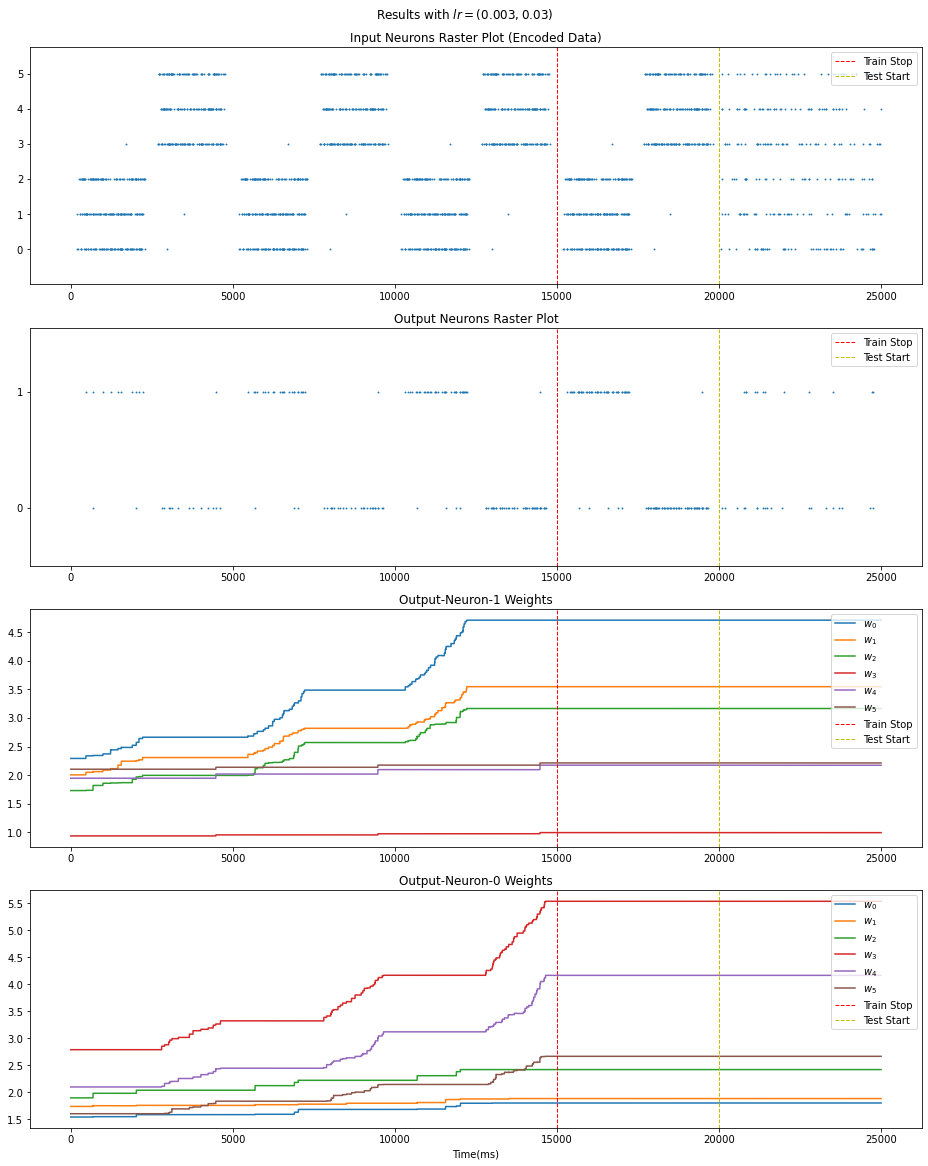

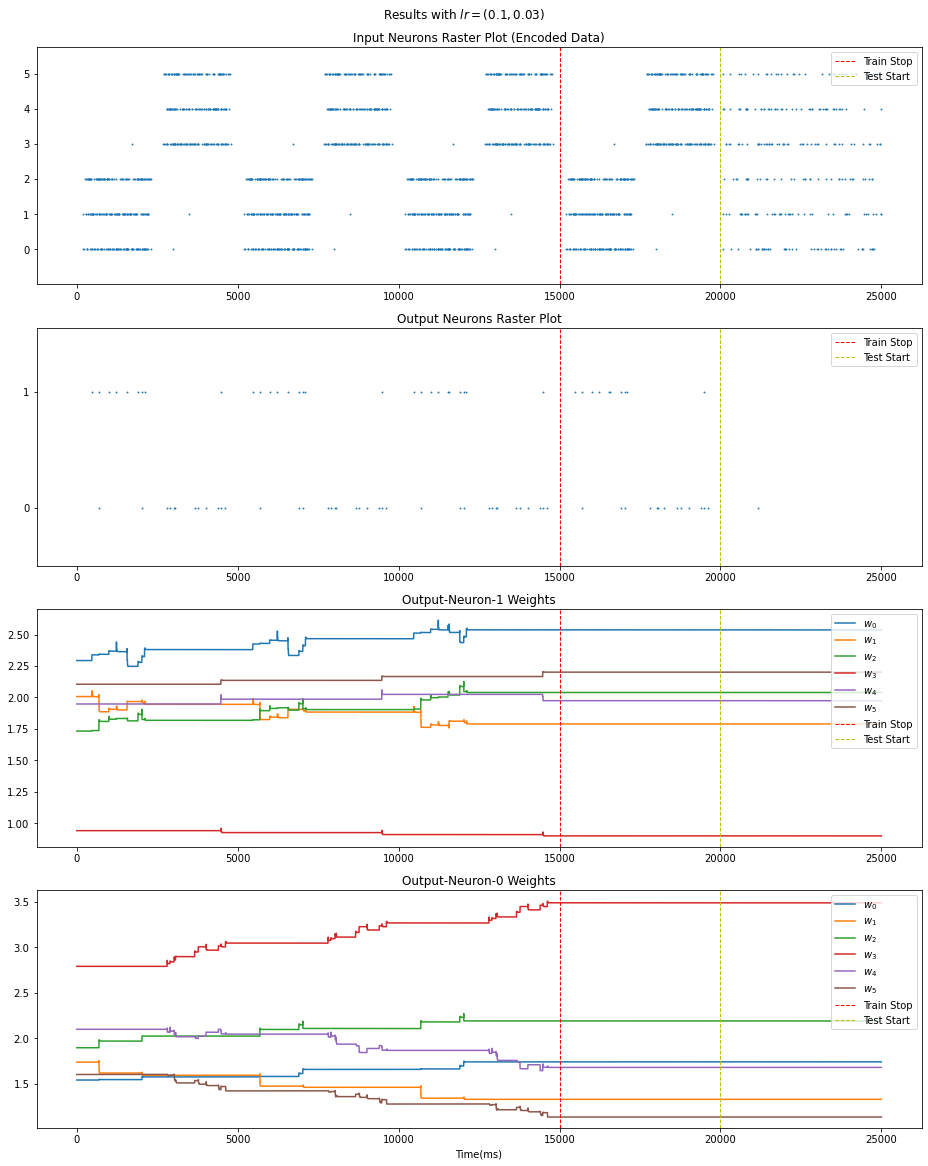

In [10]:
seed = 6626393261193957152
learning_rates = [(0.03, 0.03), (0.001, 0.03), (0.1, 0.03)]
for lr in learning_rates:
    run_stdp(lr=lr, fig_title=f"Results with $lr = {lr}$",
             random_seed=seed)

If $A_+$ is greater than $A_-$ by a large margin, the weights tend to increase
with higher slope, and they will not be corrected sufficiently when correction
is needed (when the pre-synaptic neuron spikes after the post-synaptic neuron).
As a result, the network's activation with random input increases as well. This
is visible in the network output in $[20s, 25s]$ section of the plots.
In contrast, if $A_-$ is greater than $A_+$ by a large margin, the network only
learns the desired patterns as non-ideal activations will be suppressed.
This finding hints us to use different learning rates with $A_-$ being a little
higher ($e.g. A_-=0.05, A_+=0.03$).
But we should take it into account that if the difference between the two learning
rates becomes very high, the network will lose its ability to learn completely;
either its weights suddenly saturate at the maximum value, or the weights decay to zero.

## Experiment #3 ($\tau_s$)

Low amounts of $\tau_s$ makes the weight updates more local in time. $i.e.$, the
spikes that happened in a smaller time period affect the weights. This is the
opposite for high values of $\tau_s$. Intuitively it is better to use relatively small
values for $\tau_s$ since STDP should use short time periods for updating the weights.
If $\tau_s$ becomes too high, the learning process becomes problematic since
very old spikes change the weights. This is mostly destructive with non-wanted
spikes (post-synaptic neuron spikes before pre-synaptic neuron).

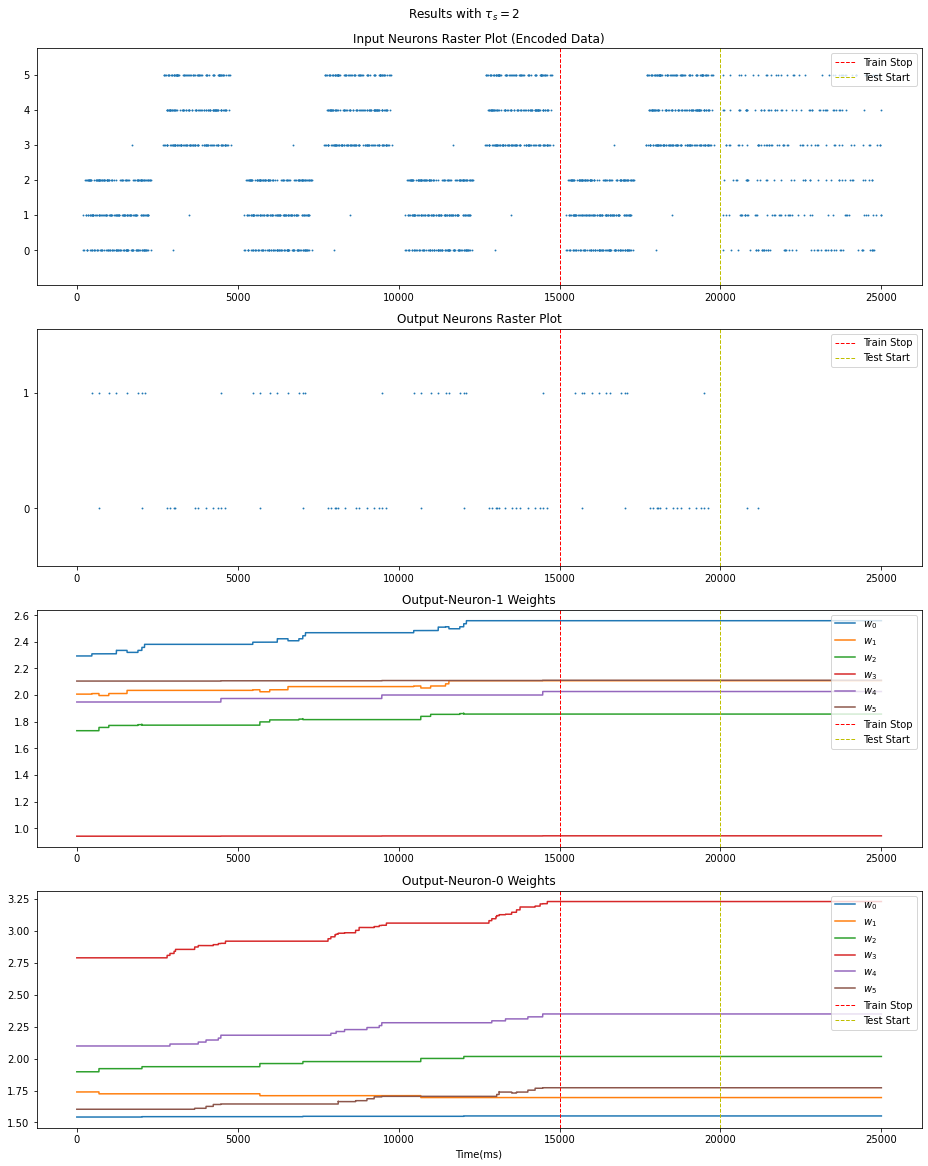

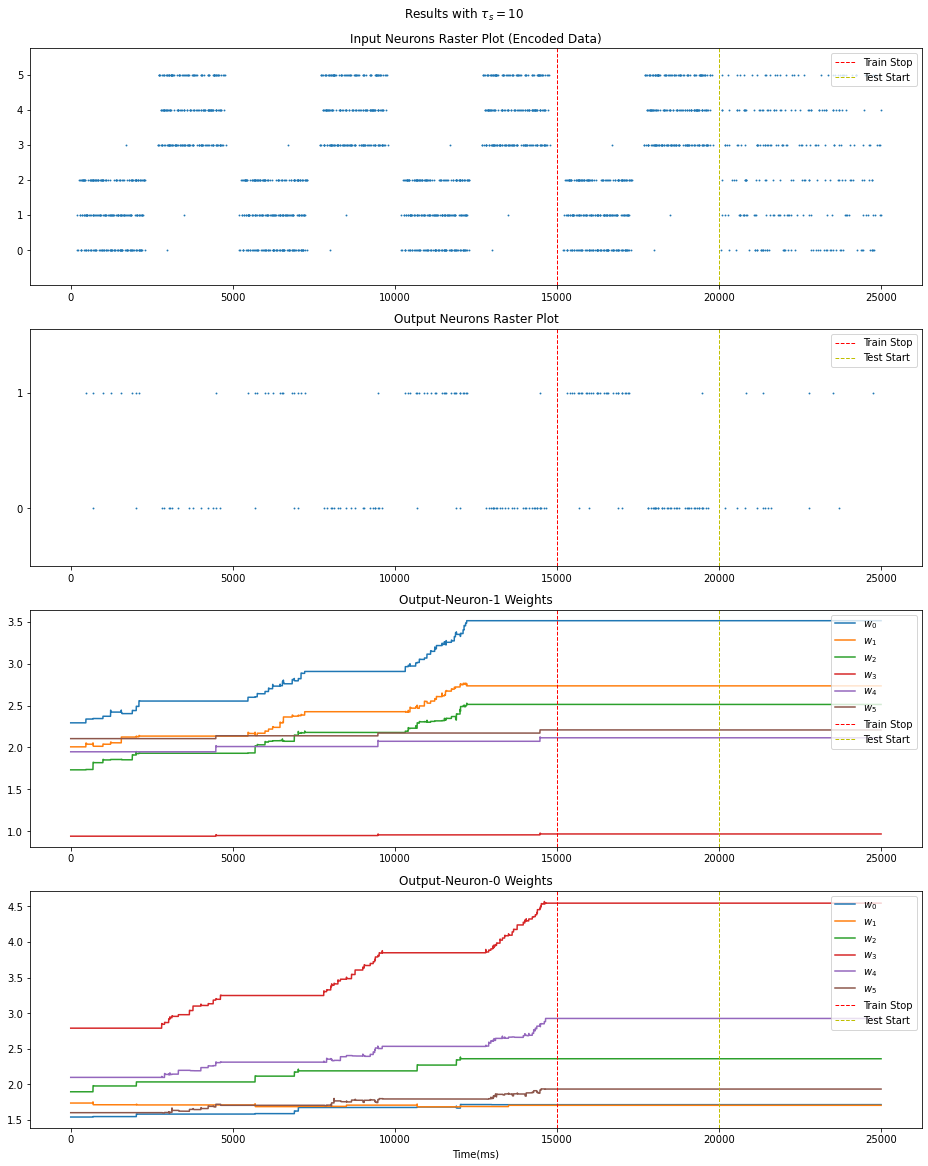

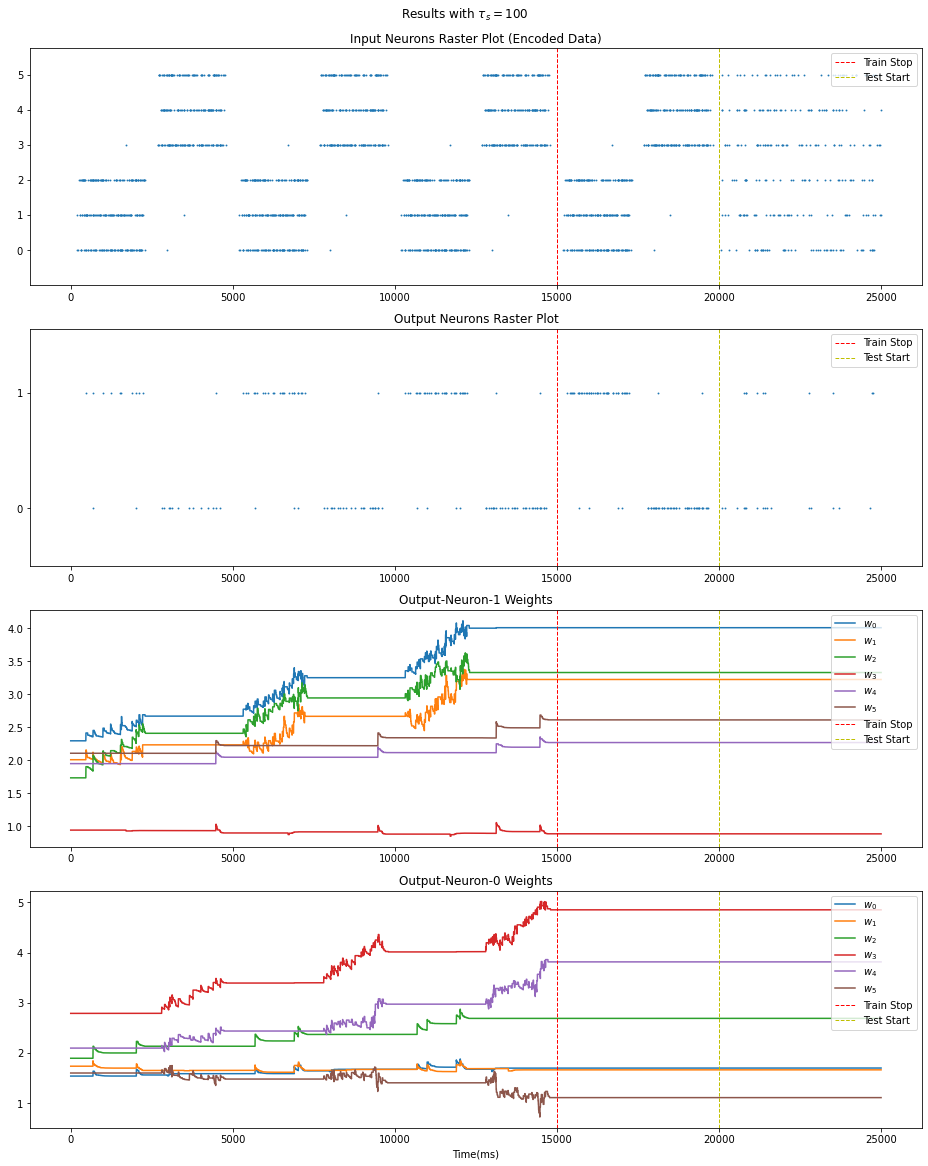

In [11]:
seed = 6626393261193957152
tau_s = [2, 10, 100]
for tau in tau_s:
    run_stdp(tau_s=tau, fig_title=rf"Results with $\tau_s = {tau}$",
             random_seed=seed, lr=[0.03, 0.03])

As stated above lower $\tau_s$, performs more reasonably as only spikes that
occurred very recently affects the learning. More reasonable means that the
network is not responding to random input in the testing phase.
But notice that with $\tau_s=2$, the total amount of output neurons' activation
has become lowered. This is because the weight updates are happening more slowly;
therefore, the learning takes longer time.

# Flat-STDP

To implement Flat-STDP, we binarized the spike-traces with a fixed threshold
of 0.05. If the traces are greater than 0.05, they will be set to 1 and 0 otherwise.

## Default Parameters

**Train Params:**

$\qquad Time_{simulation} = 25000ms$

$\qquad LearningRates = [0.025, 0.075]$

$\\$
**Neurons Params:**

$\qquad Num(PresynapticNeurons) = 6$

$\qquad \tau_s=10ms$

$\qquad Threshold=-52mv$

$\qquad U_{rest}=-60mv$

$\\$

**Connection Params:**

$\qquad J_0 = 11$

$\qquad \sigma_0 = 2.5$

$\qquad Weight_{min} = 0$

$\qquad Weight_{max} = 7.5$


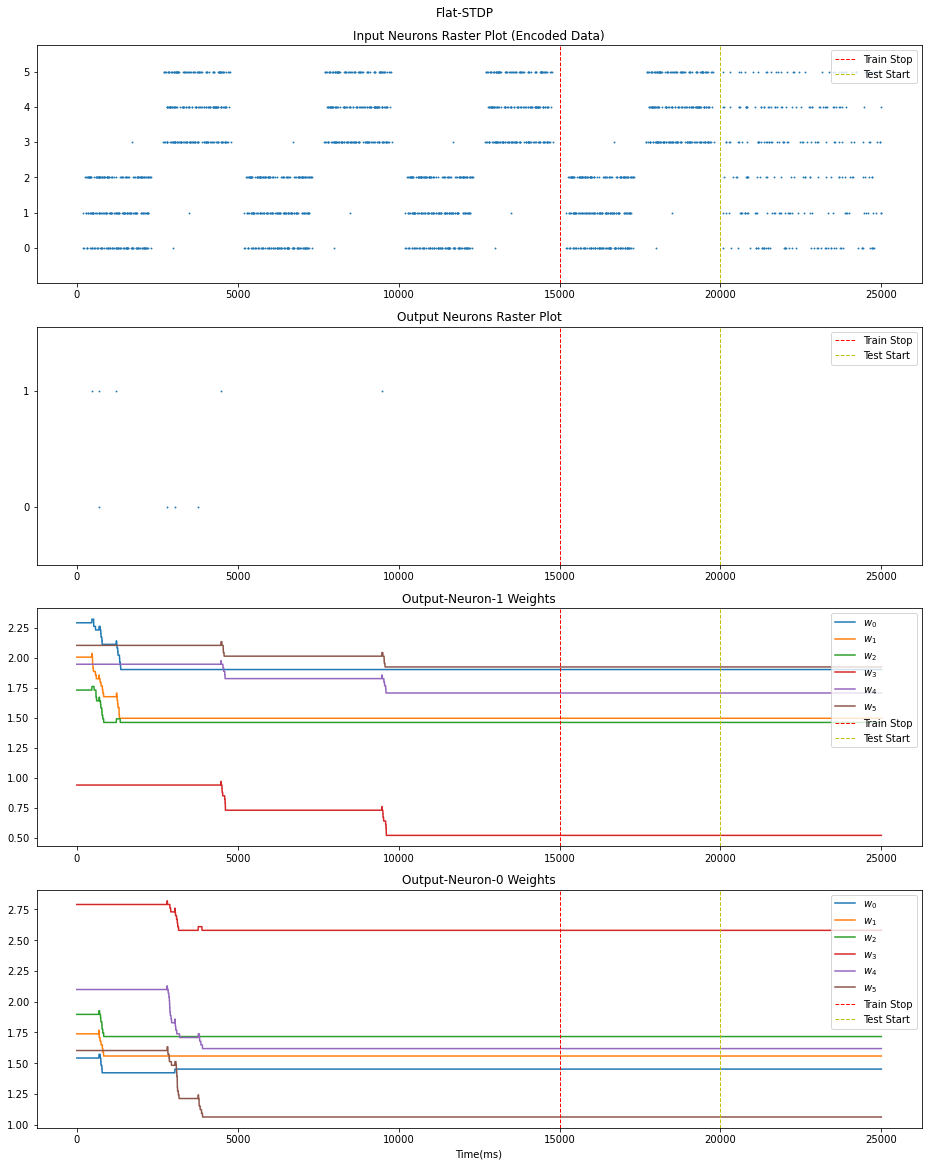

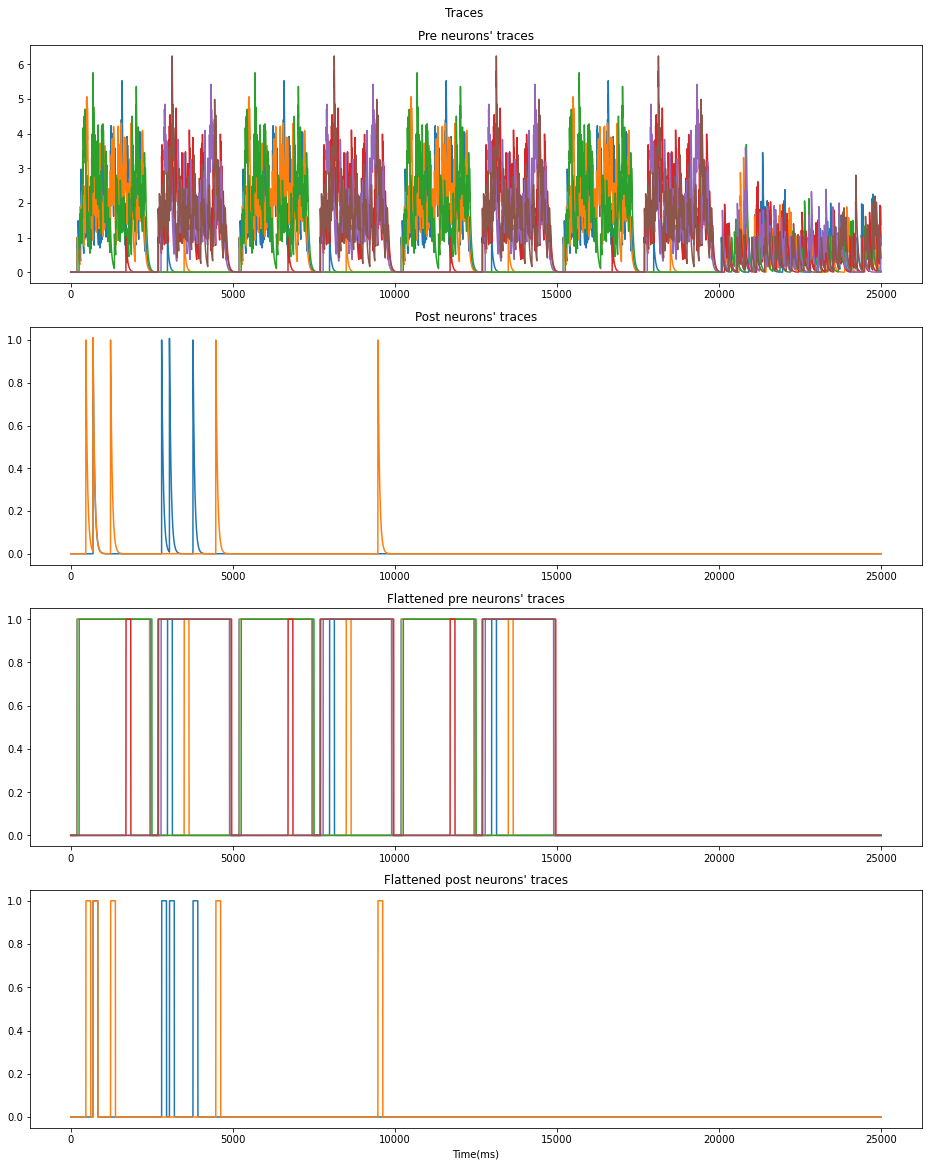

In [30]:
seed = 6626393261193957152
_, net = run_stdp(fig_title=f"Flat-STDP",
         is_flat=True, monitor_traces=True,
         random_seed=seed, tau_s=50, learning_rates=[0.025, 0.075])

fig, ax = plt.subplots(4, figsize=(13, 17))
fig.suptitle('Traces')
ax[0].plot(net.monitors["monitor_in"].get("traces"))
ax[1].plot(net.monitors["monitor_out"].get("traces"))
ax[2].plot(net.monitors["monitor_learning"].get("pre_traces"))
ax[3].plot(net.monitors["monitor_learning"].get("post_traces"))
ax[0].title.set_text("Pre neurons' traces")
ax[1].title.set_text("Post neurons' traces")
ax[2].title.set_text("Flattened pre neurons' traces")
ax[3].title.set_text("Flattened post neurons' traces")
ax[3].set_xlabel('Time(ms)')
fig.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

In the above plots we have set $\tau_s=50$ to make the changes in the traces
more visible. Due to the fact that the traces are now flattened and $\tau_s$
is increased compared with the previous experiments, the weights are decreasing instead
of increasing, so the network is not learning anything. In the following experiments
we don't plot the traces anymore and better parameters for the network.

## Experiment #1 (Initial Weights)

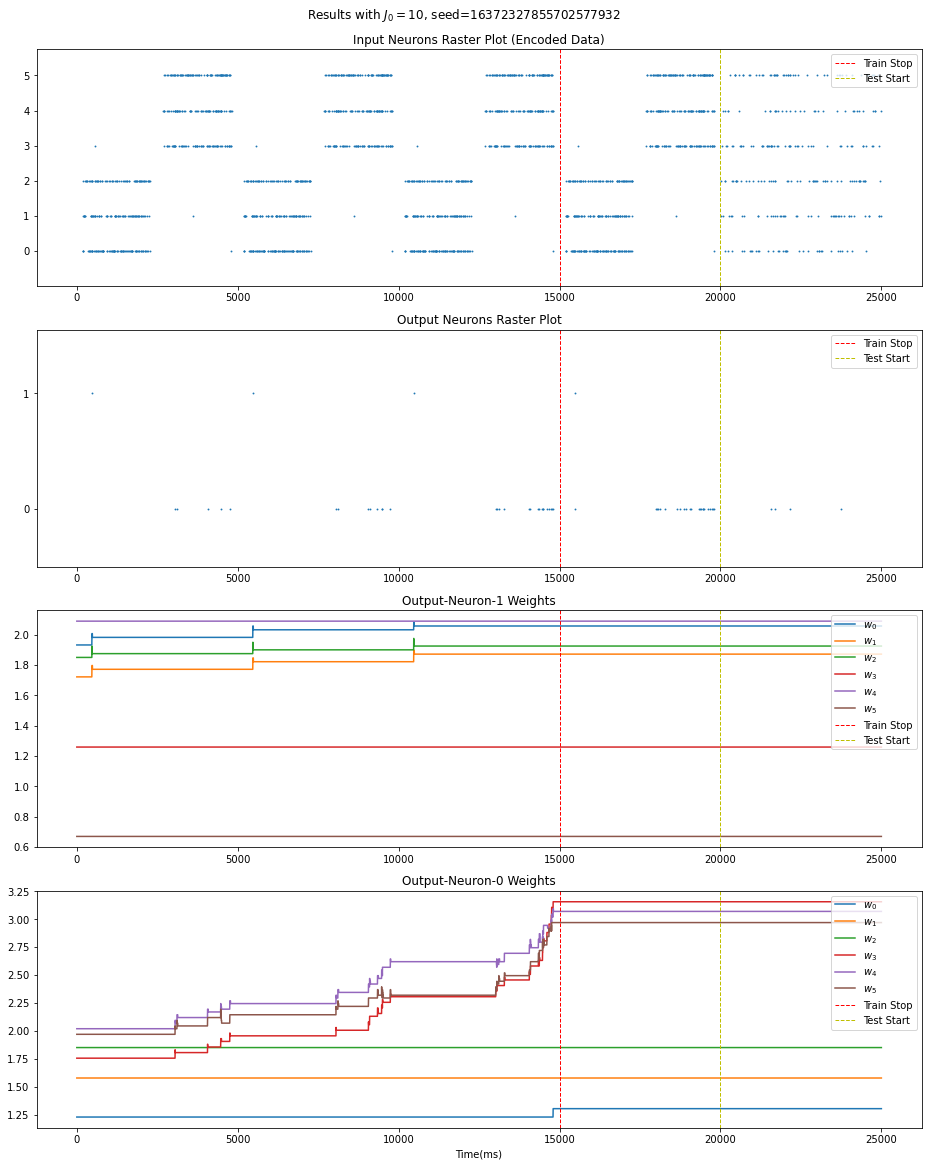

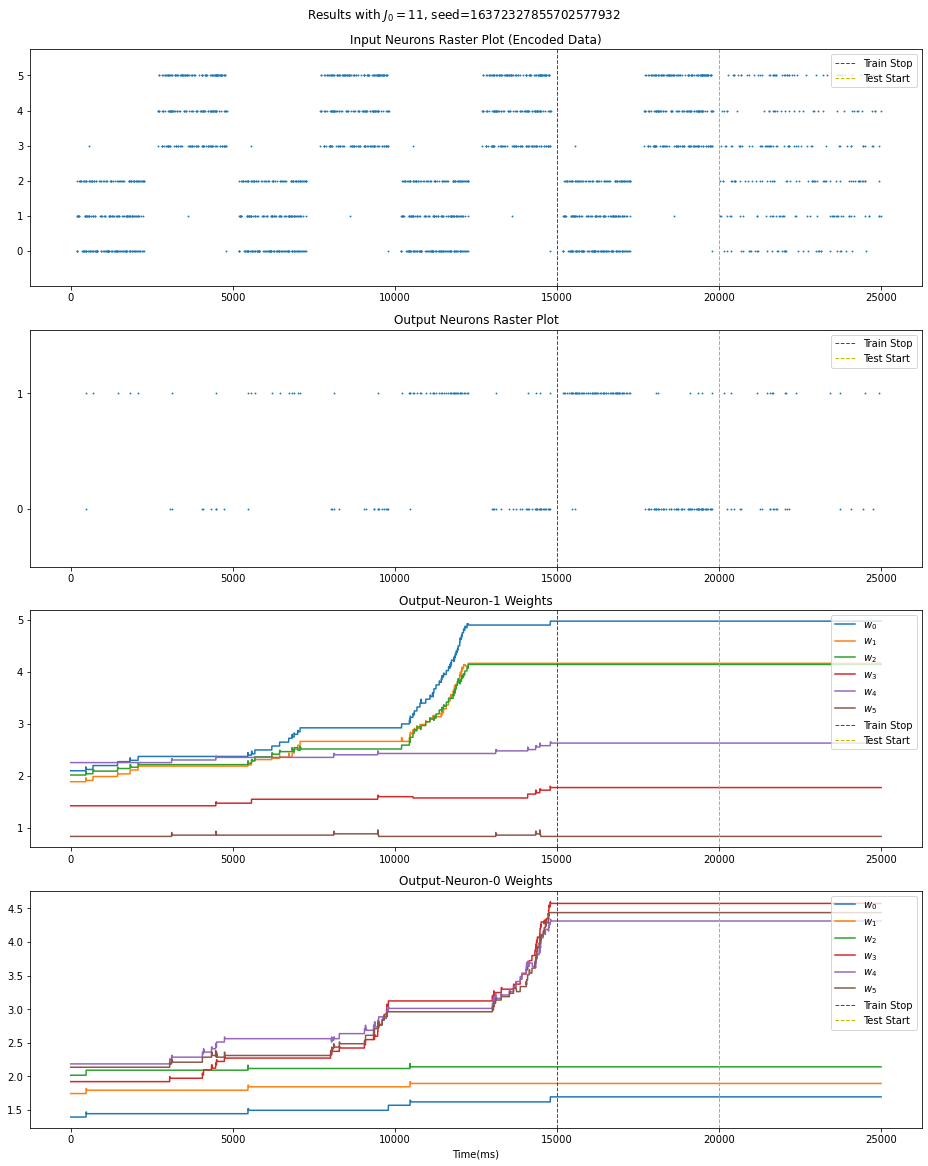

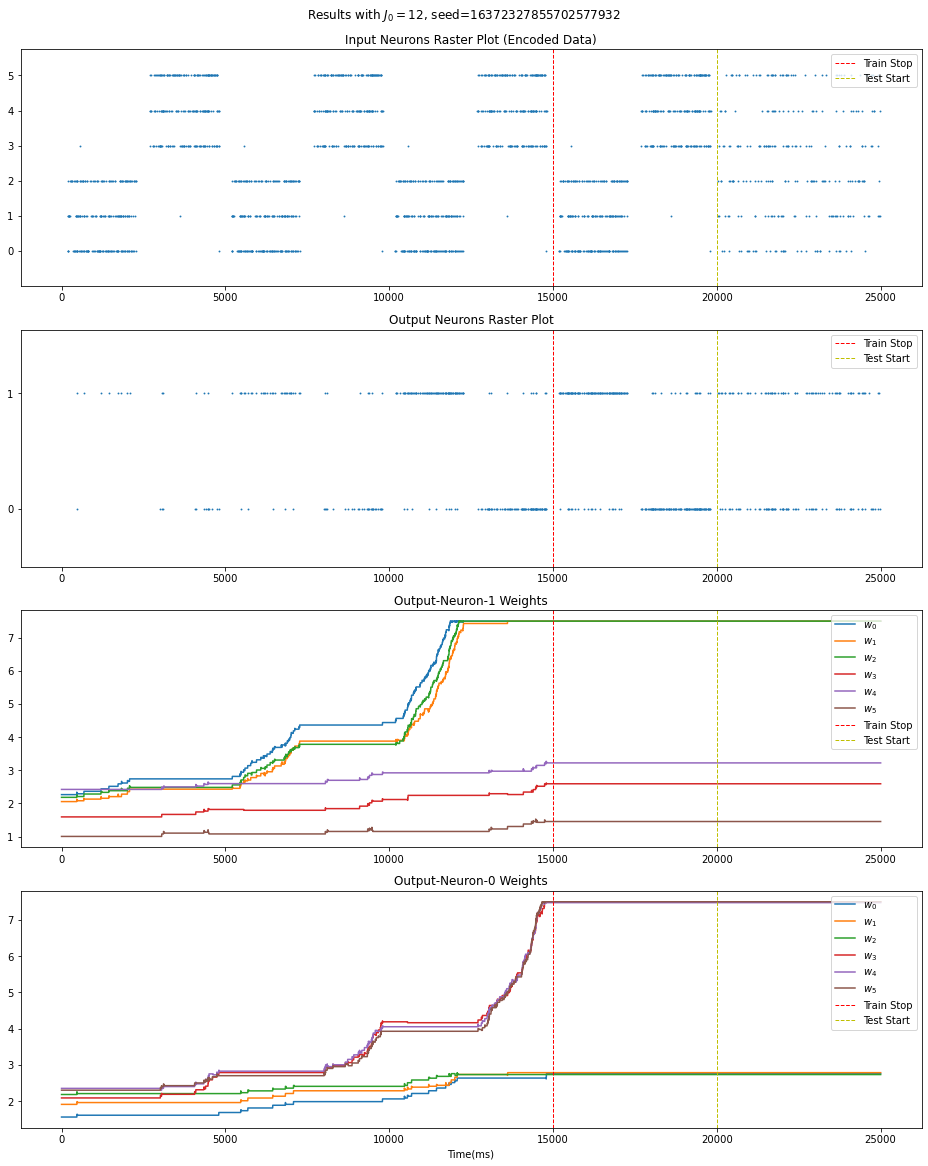

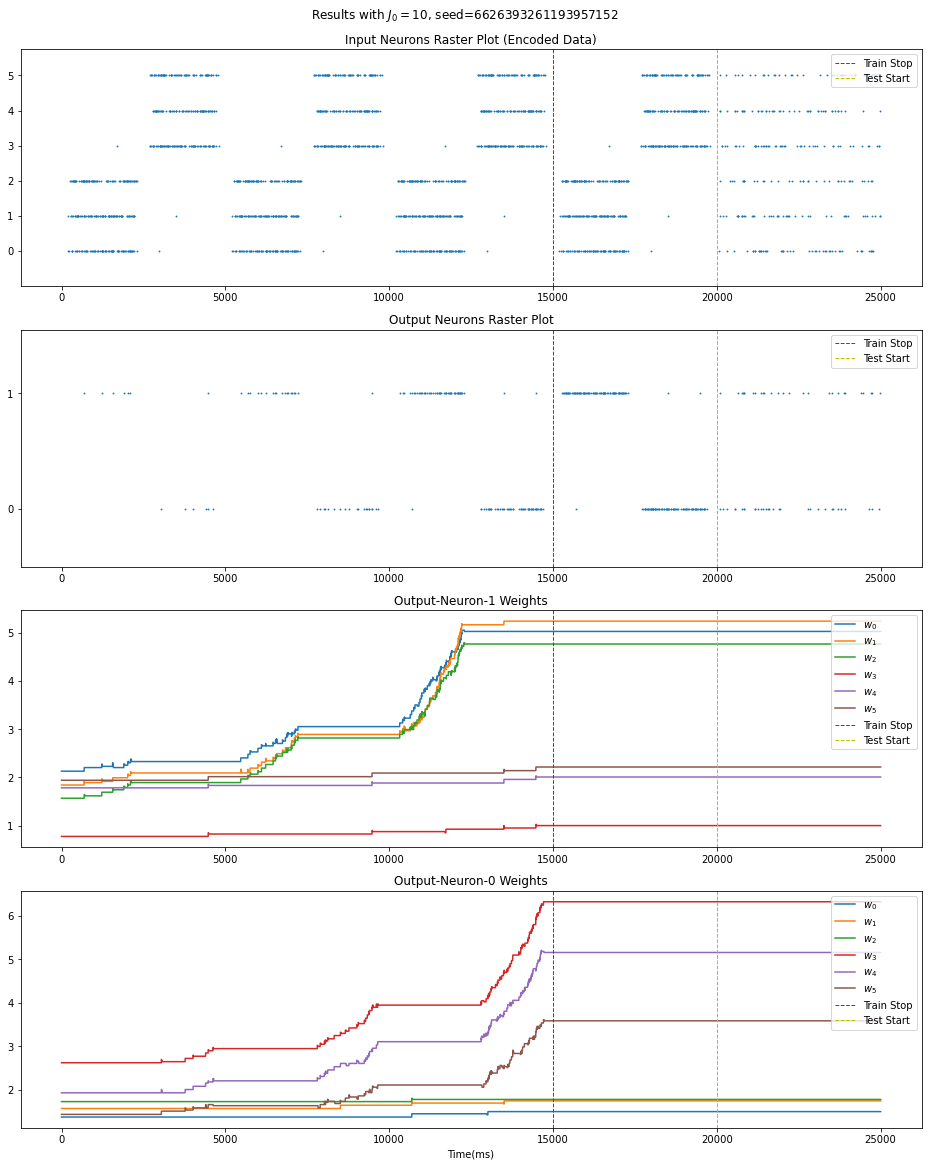

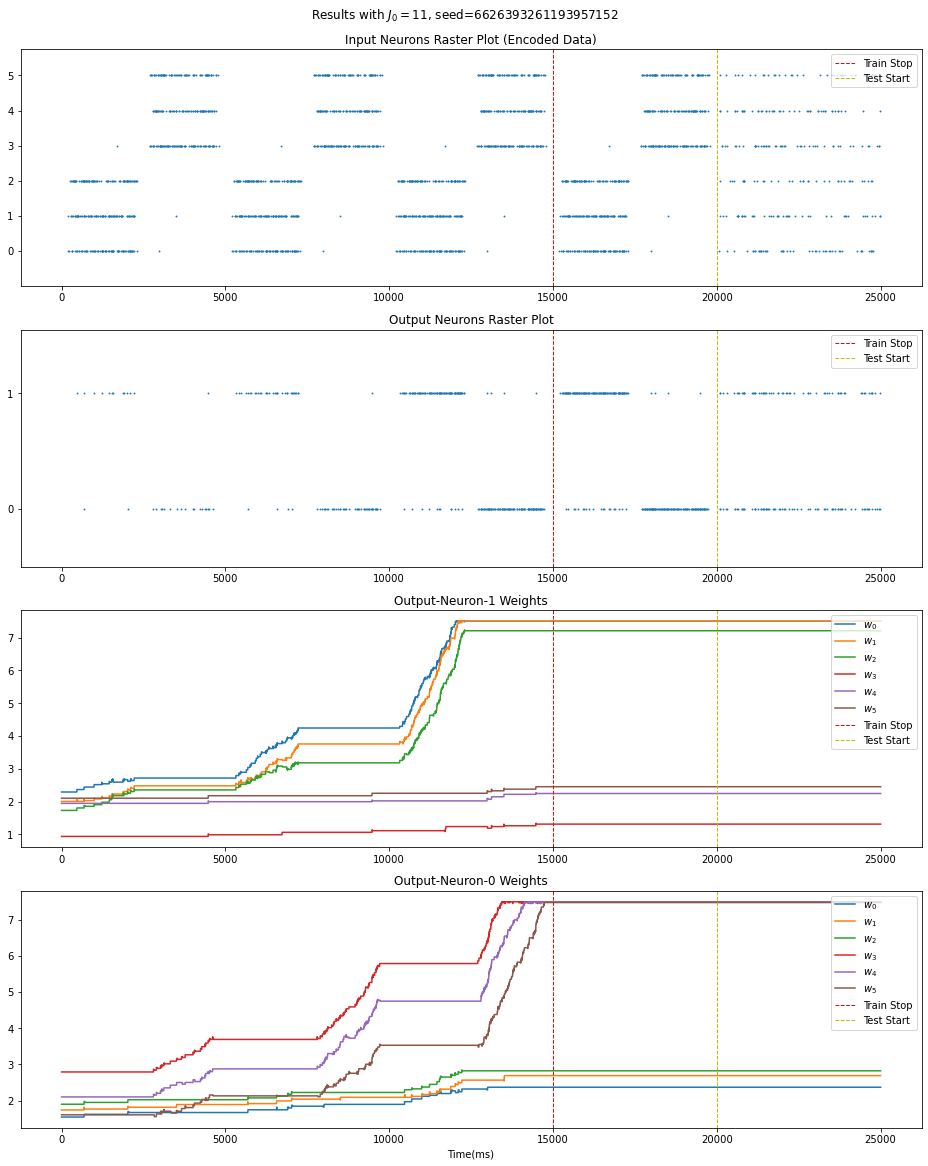

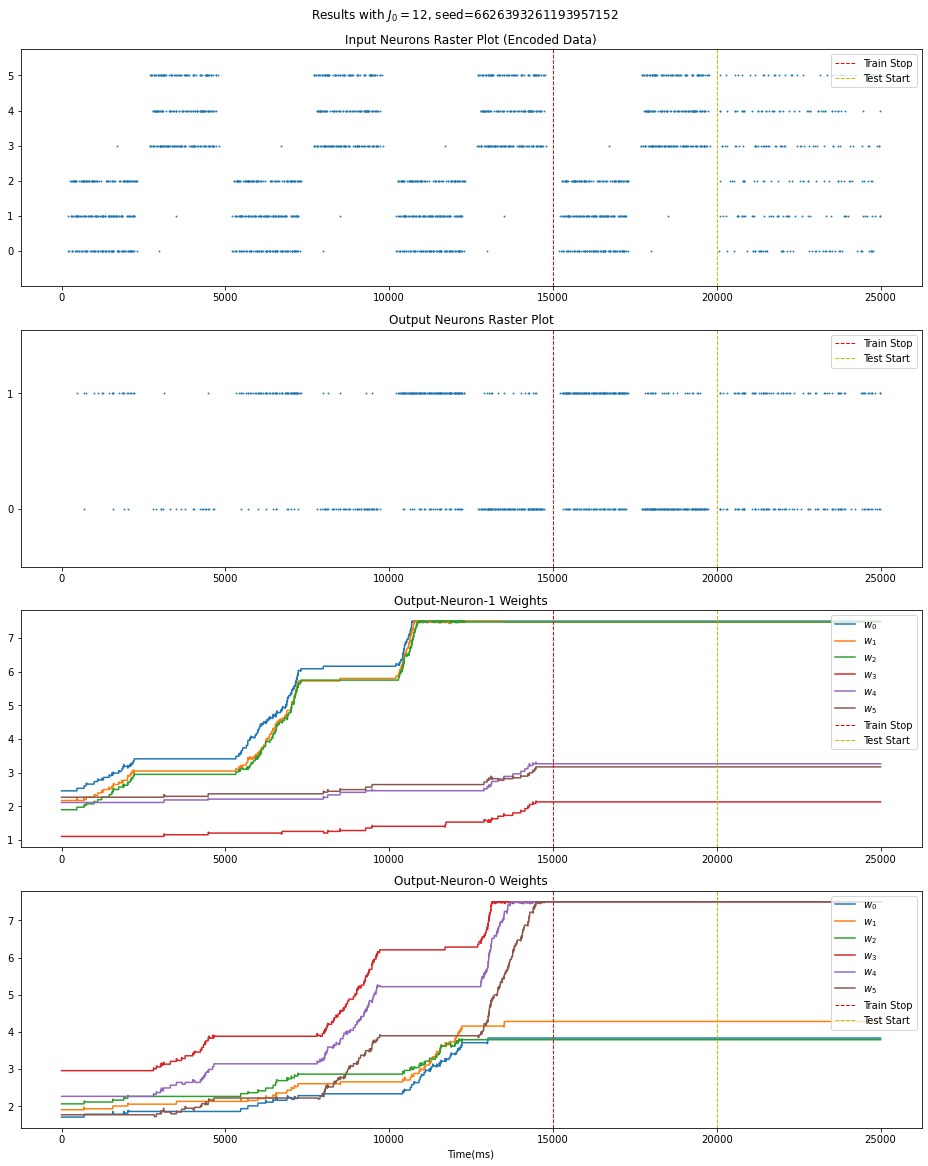

In [13]:
seeds = [16372327855702577932, 6626393261193957152]

j0s = [10, 11, 12]
for seed in seeds:
    for j0 in j0s:
        _, net = run_stdp(fig_title=f"Results with $J_0 = {j0}$, seed={seed}",
                          is_flat=True, random_seed=seed,
                          lr=[0.025, 0.075], j0=j0)

The conclusion of the above plots is the same as we made in STDP section.

## Experiment #2 (Learning Rates)

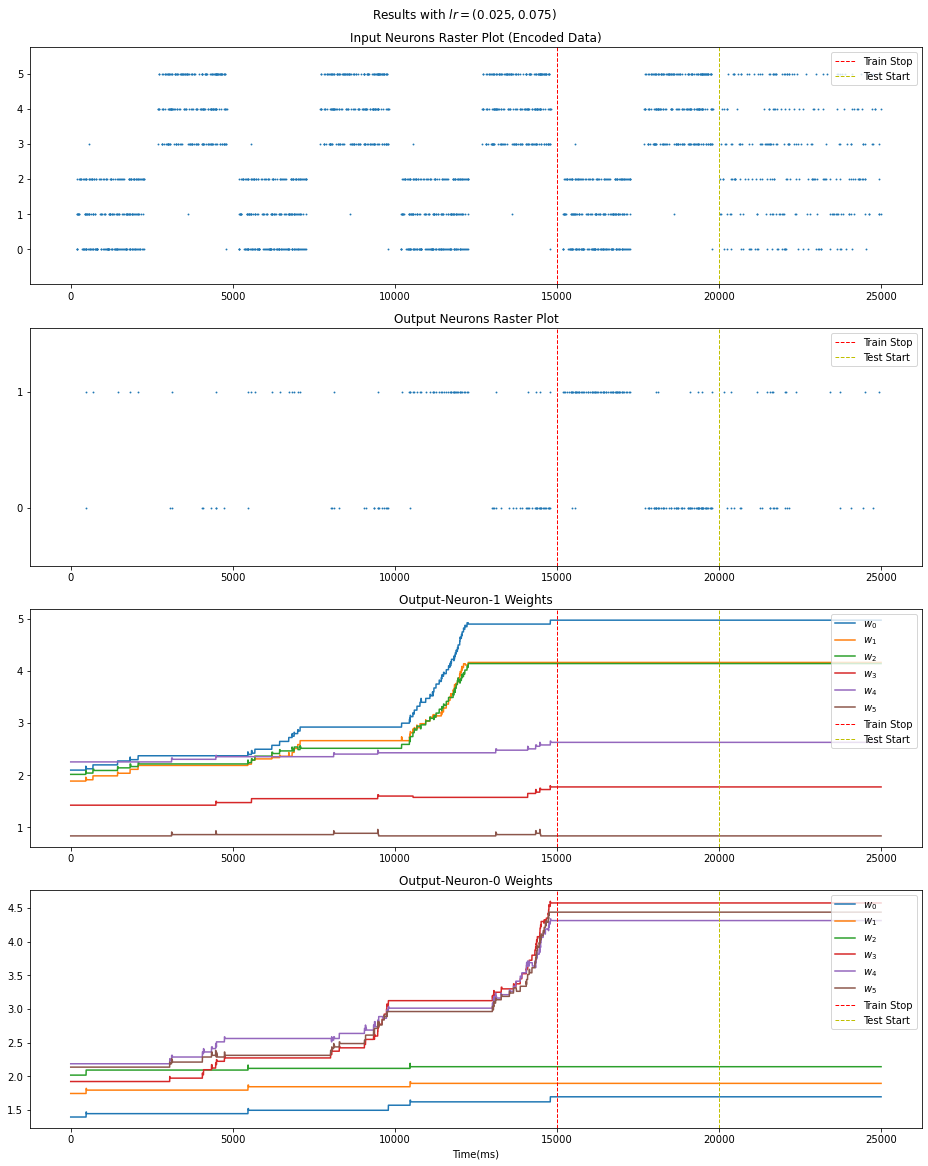

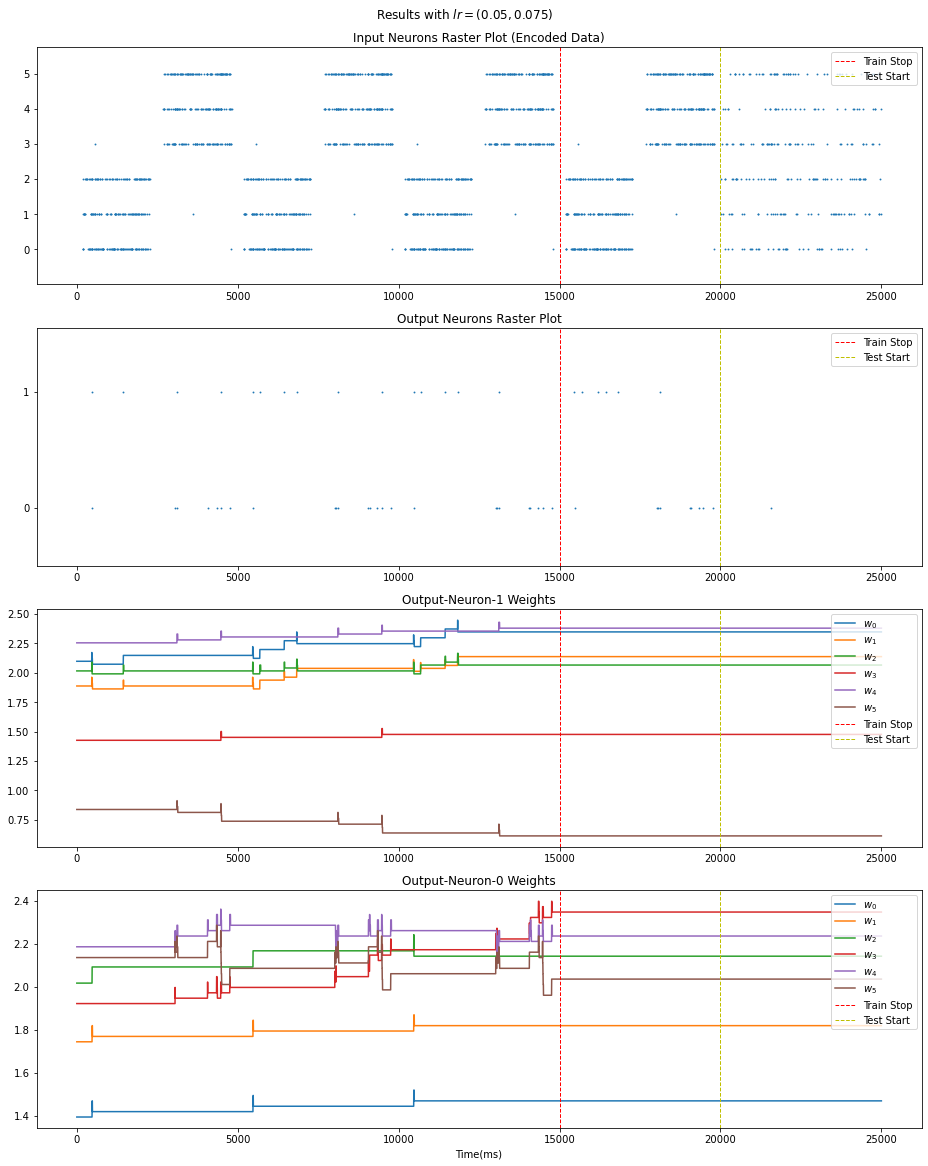

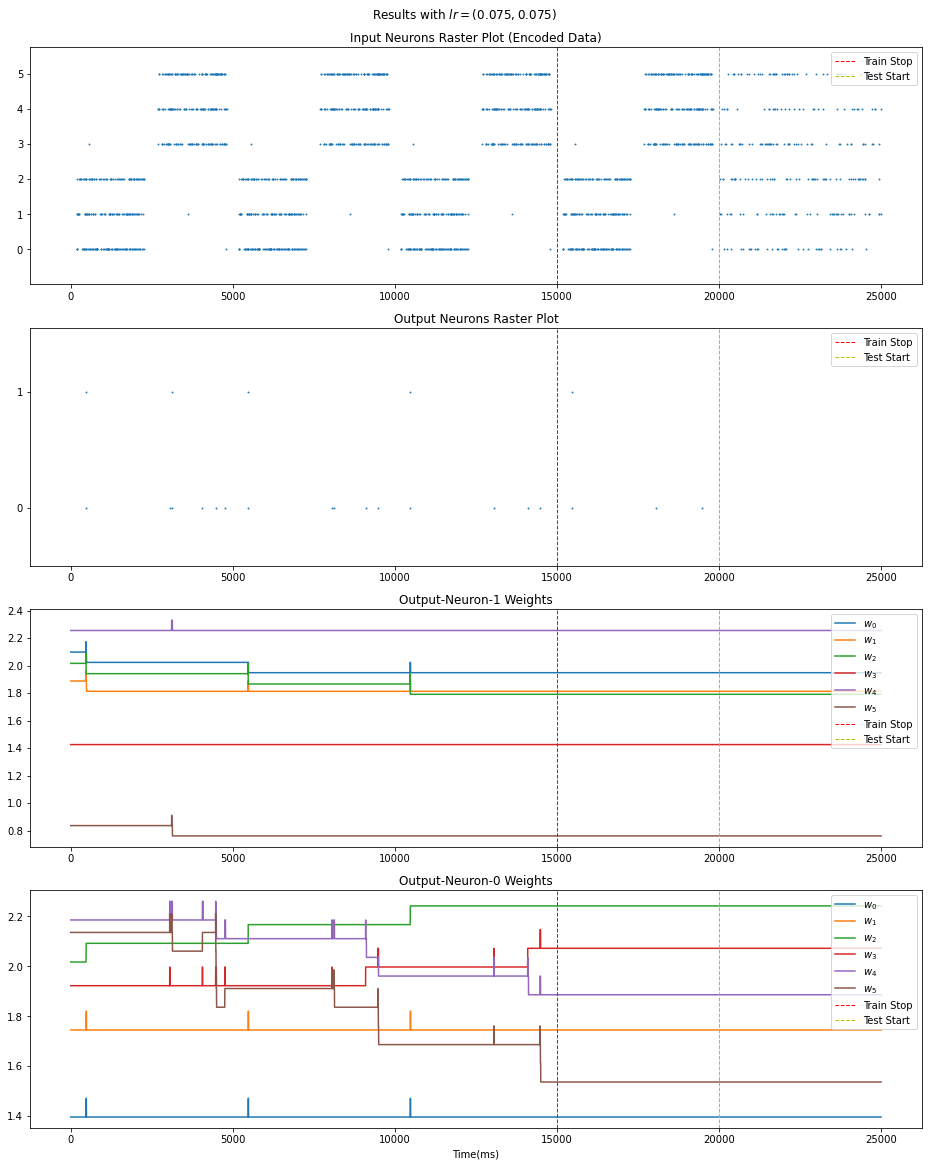

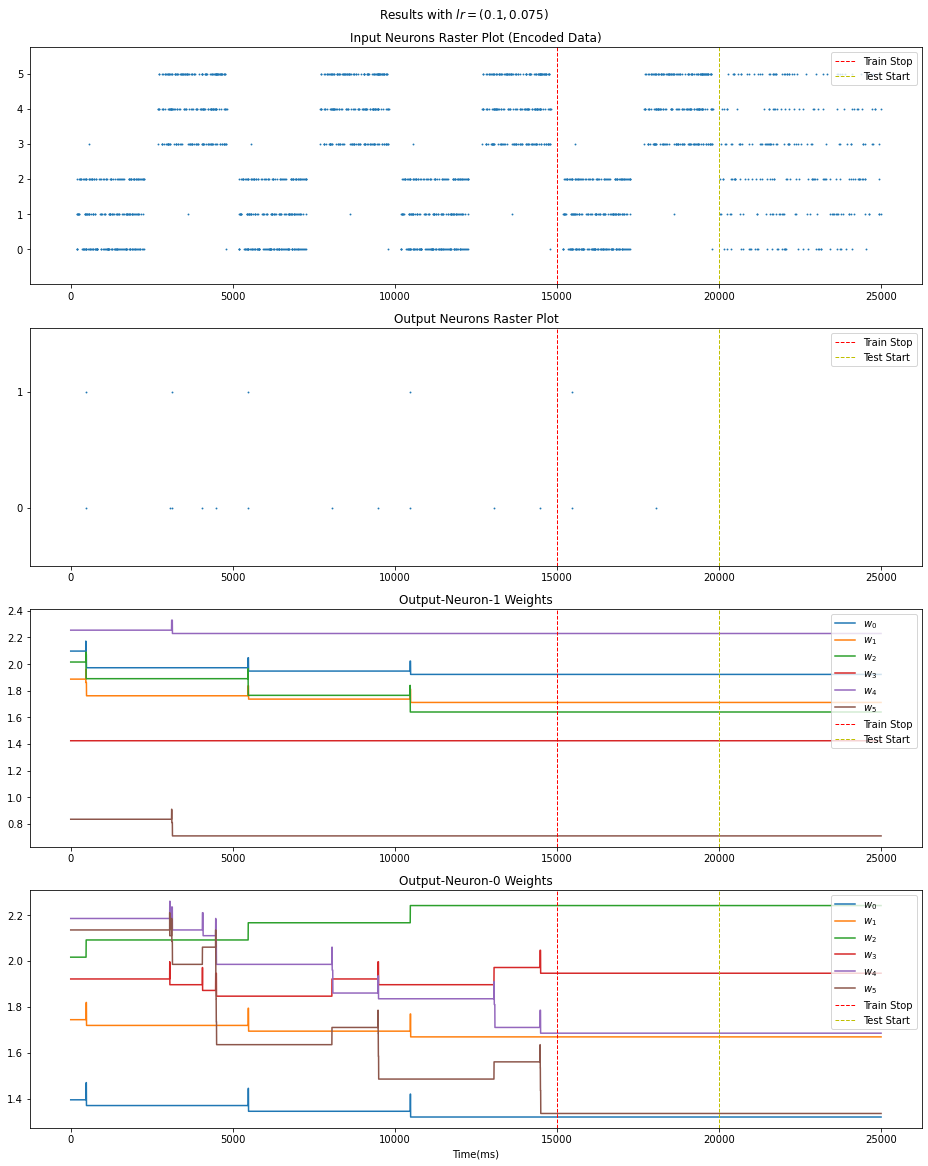

In [14]:
seed = 16372327855702577932
learning_rates = [(0.025, 0.075), (0.05, 0.075), (0.075, 0.075), (0.1, 0.075)]
for lr in learning_rates:
    run_stdp(lr=lr, fig_title=f"Results with $lr = {lr}$", is_flat=True,
             random_seed=seed)

The difference between this experiment, and the one for STDP is that
the same learning rates with the same input results in different learnt weights
and different network activity, which is not unexpected. Another difference
is that in STDP learning rule, it was better to keep $A_-$ a little higher than
$A_+$; but here, it is the opposite in most of the cases (random seeds). The
reason is that higher $A_-$ in Flat-STDP do not let the weights to be learned
efficiently, and the amount of decrease in the weights would be higher than
the amount of increase if the input's frequency is a bit high (like our inputs).

### Comparing Flat-STDP with STDP

The below plot uses the same learning rates as we used for STDP.

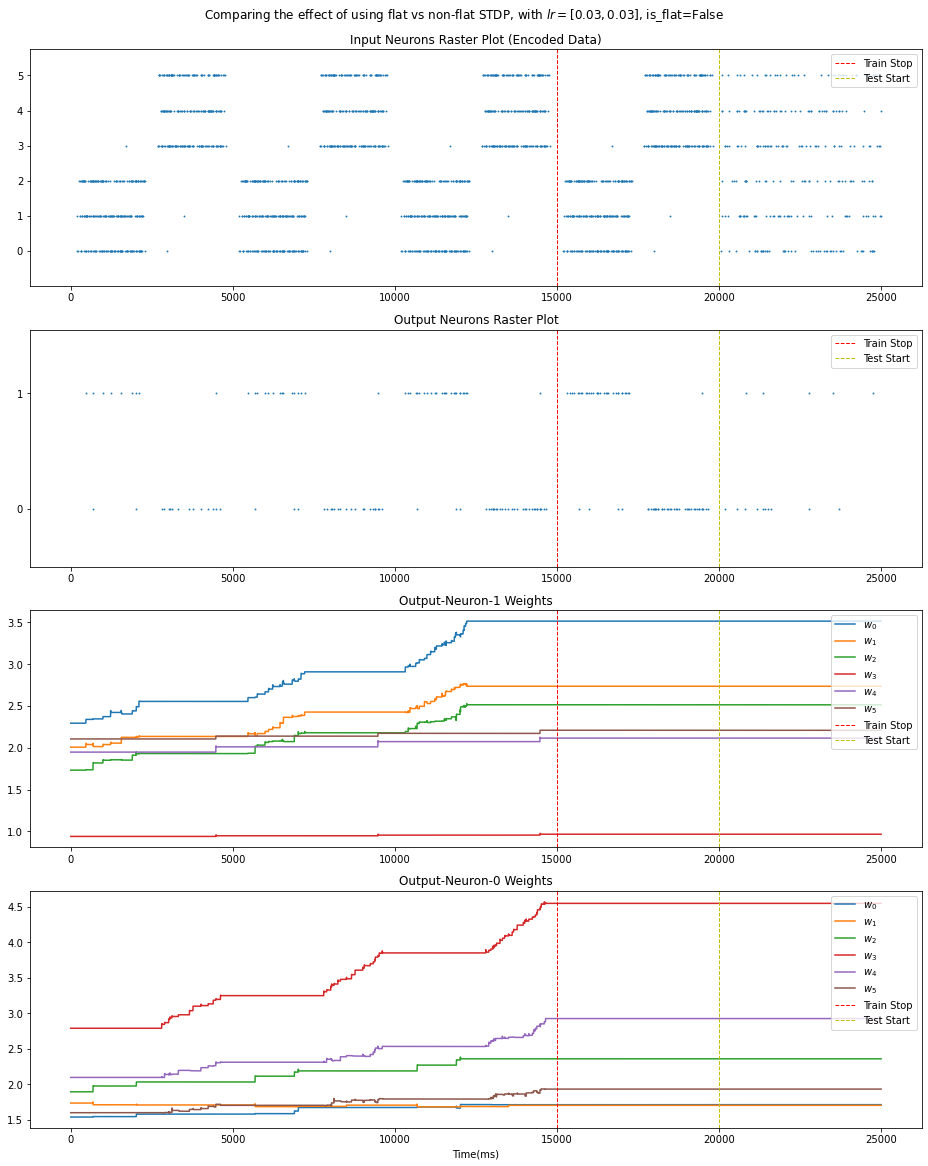

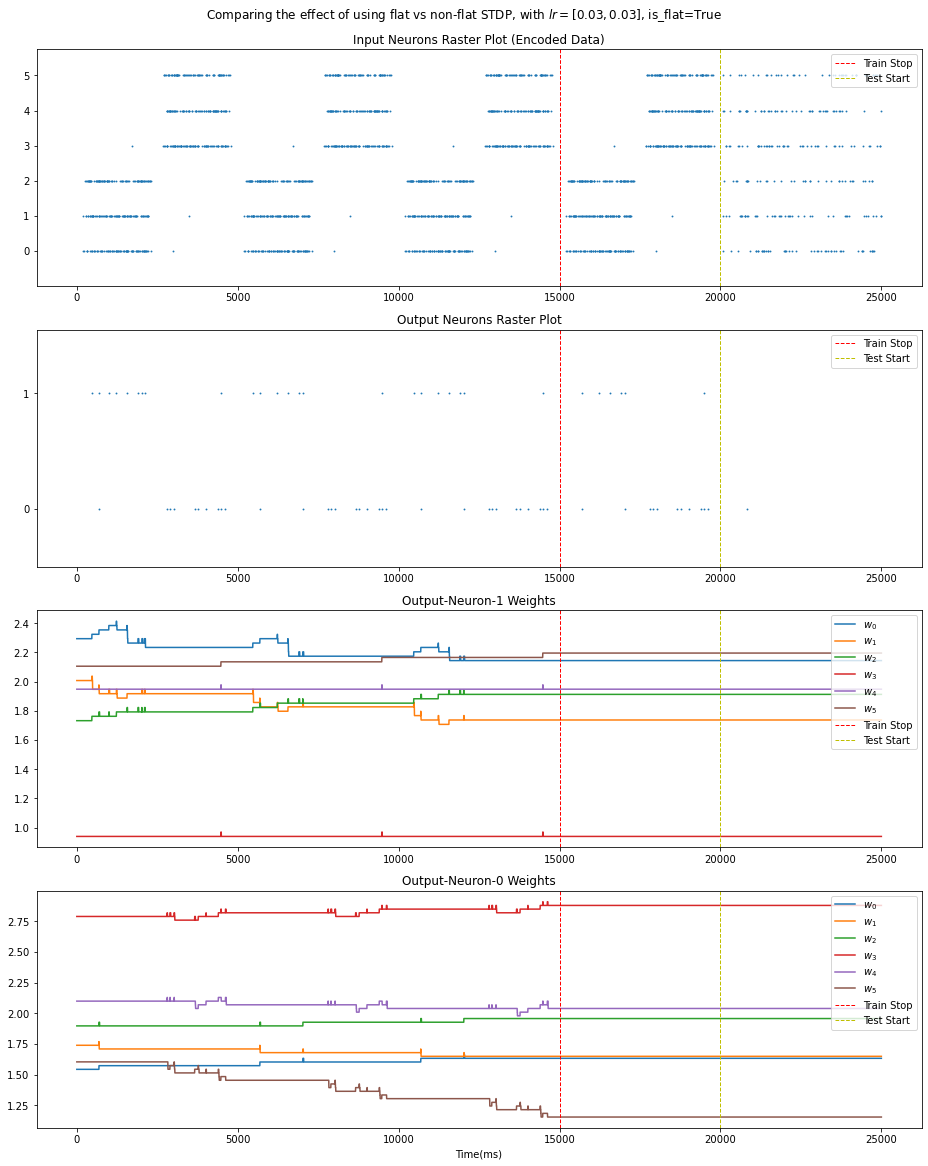

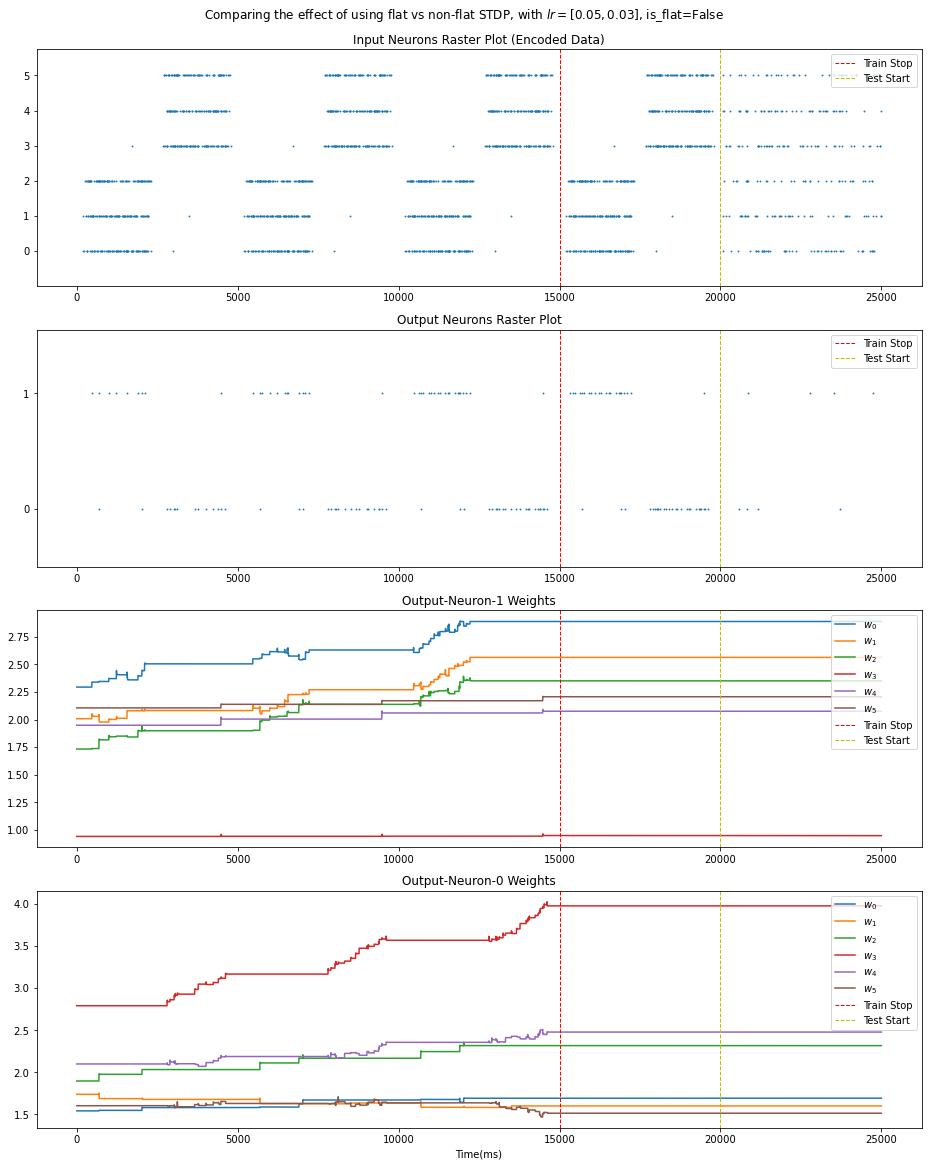

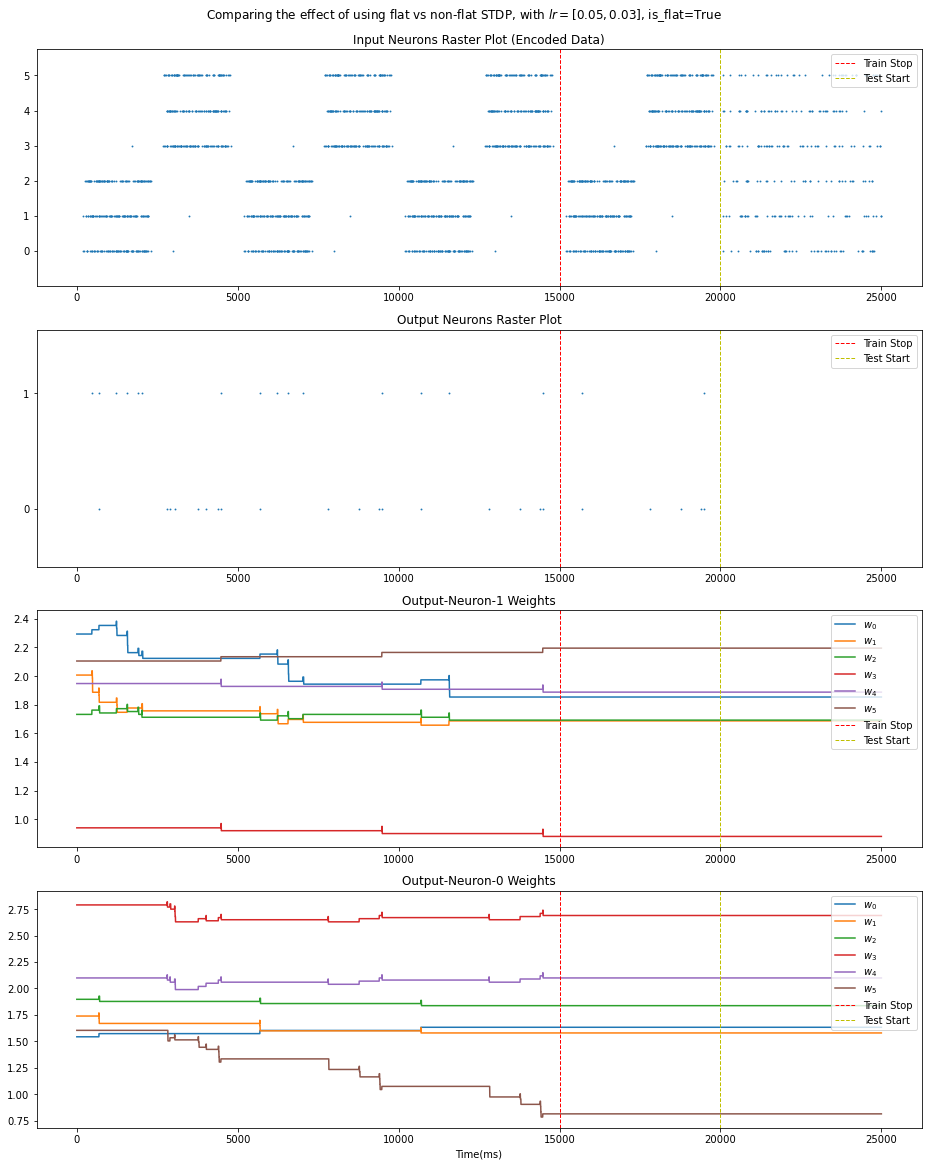

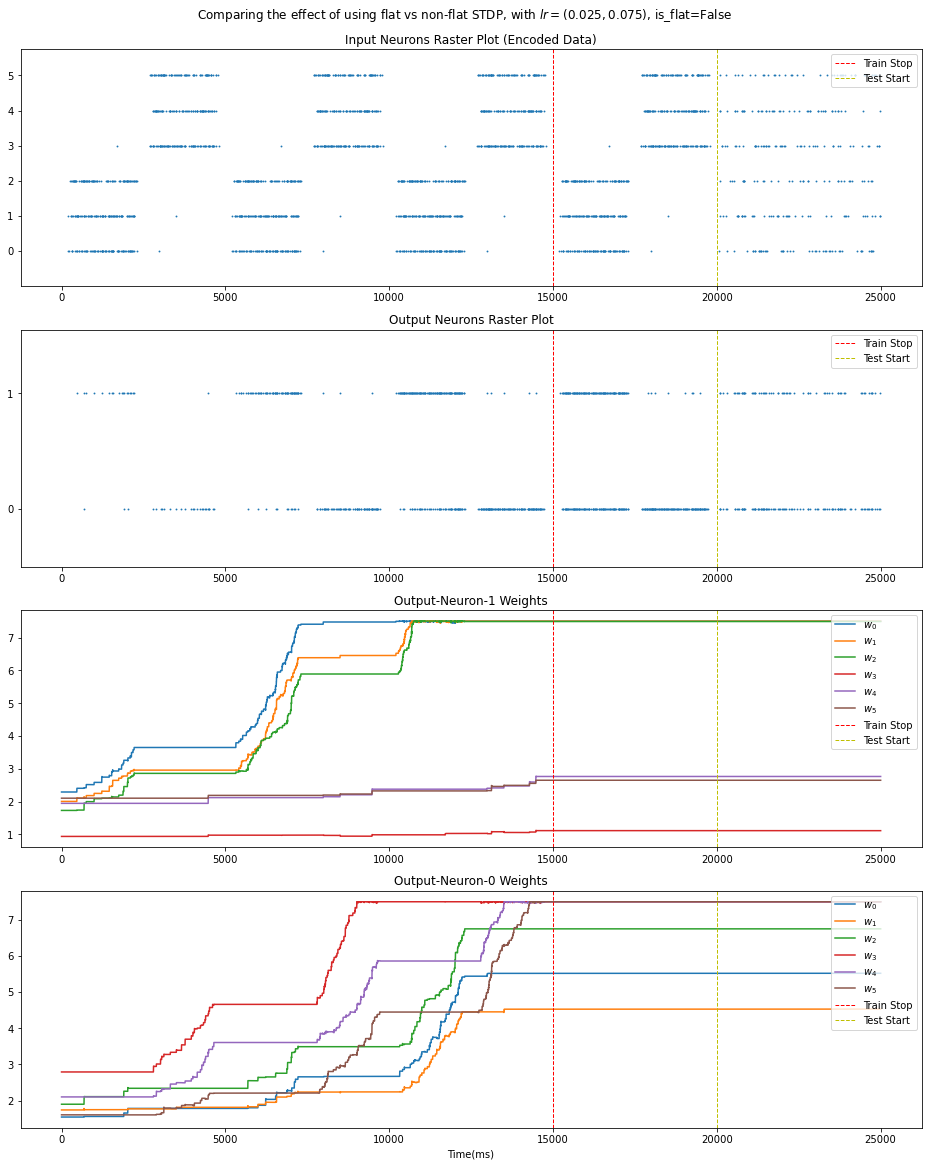

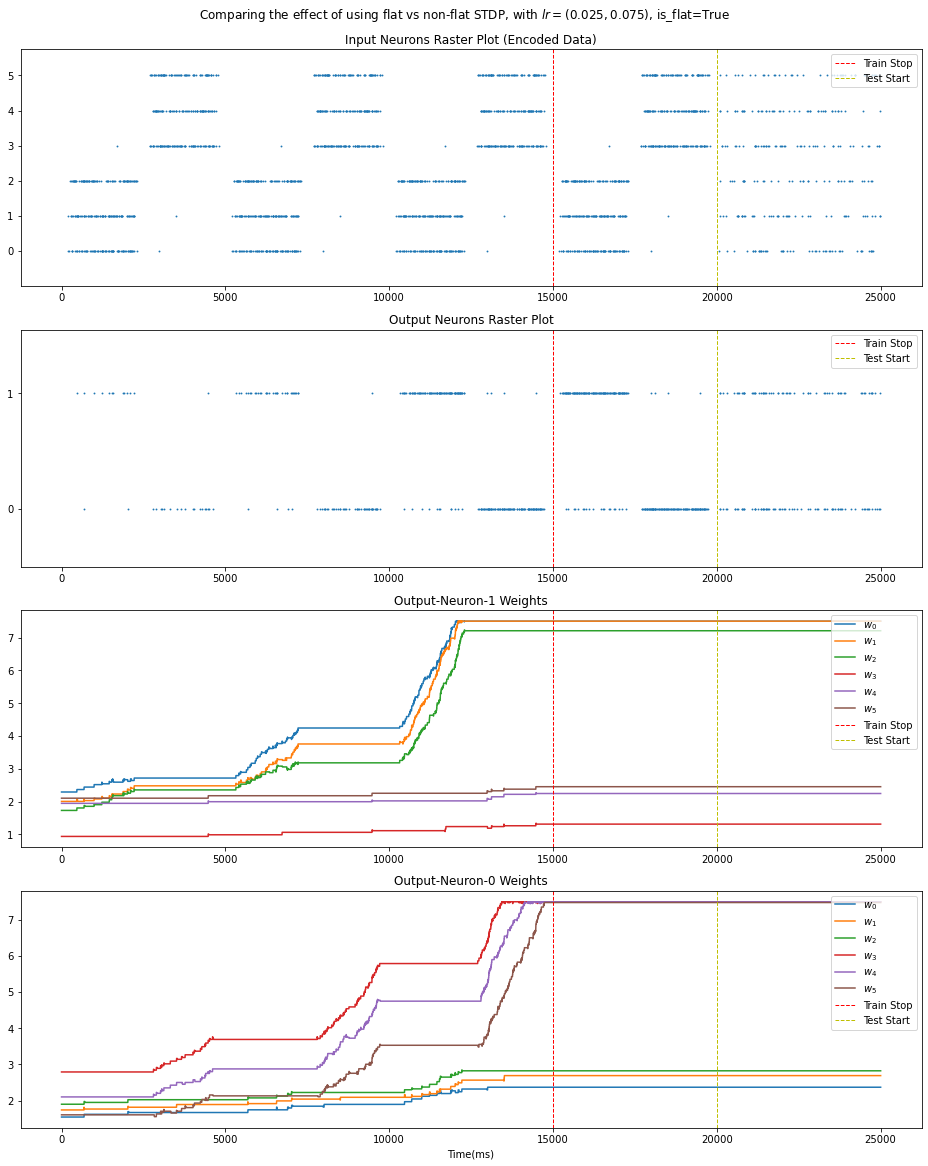

In [15]:
seed = 6626393261193957152
is_flat = [False, True]
learning_rates = [[0.03, 0.03], [0.05, 0.03], (0.025, 0.075)]
for lr in learning_rates:
    for flat in is_flat:
        run_stdp(lr=lr,
                 fig_title=f"Comparing the effect of using flat vs non-flat STDP"
                           f", with $lr = {lr}$, is_flat={flat}",
                 is_flat=flat,
                 random_seed=seed)

We see that in some cases despite the fact that F-STDP is simpler, it works
as good as non-flat-STDP and even better in some other cases ($lr=[0.025, 0.075]$).
 The only thing
 to consider is to change the learning rate when switching from STDP to F-STDP.
 So, it is favorable
to use F-STDP because it works as good as STDP but is simpler.

## Experiment #3 ($\tau_s$)

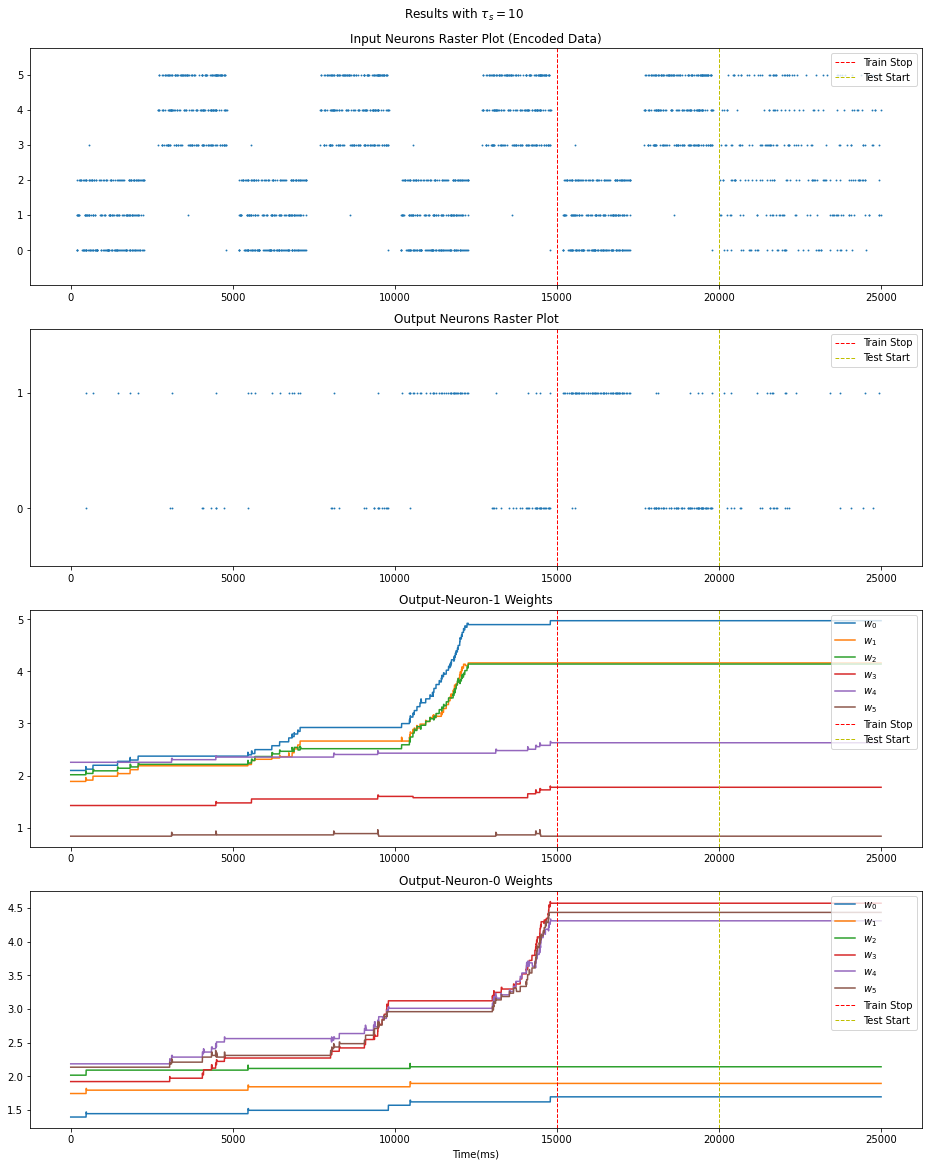

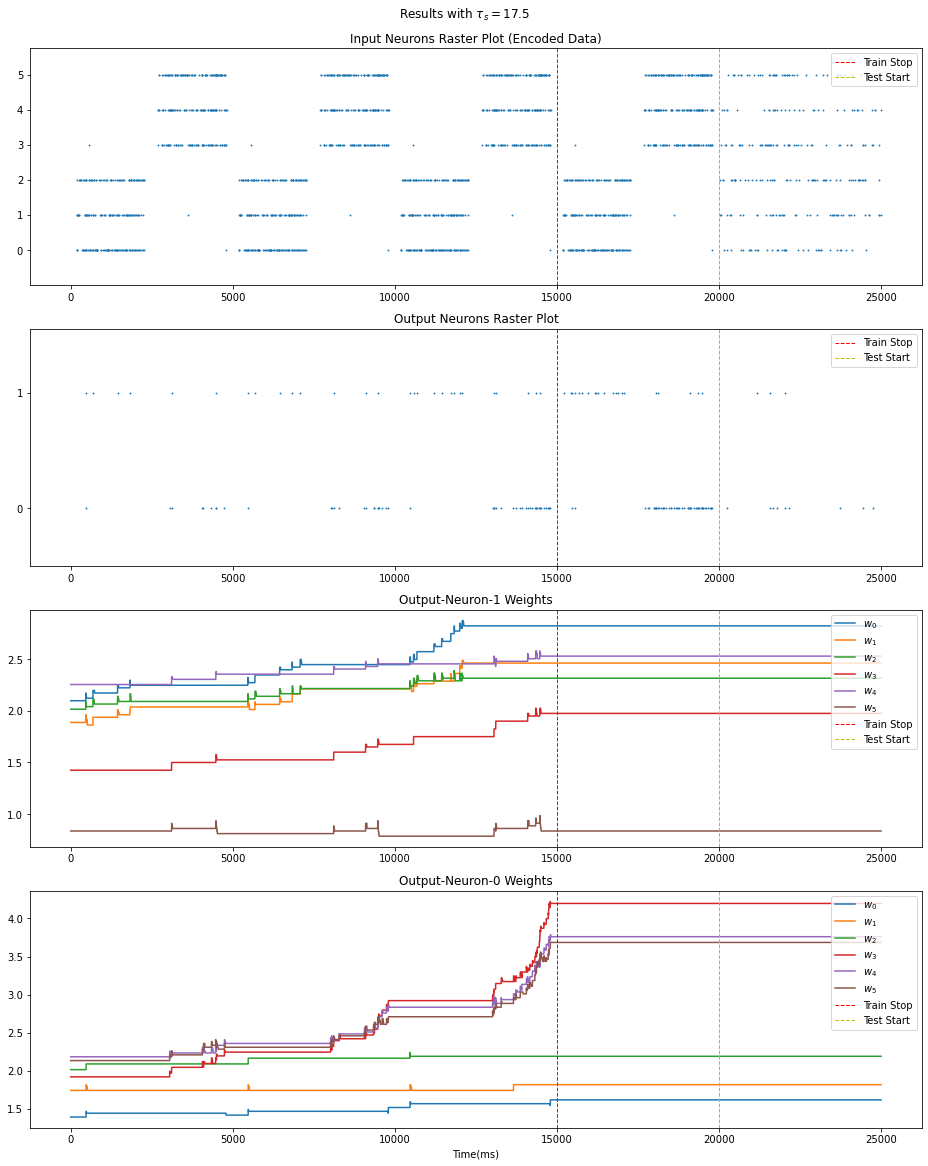

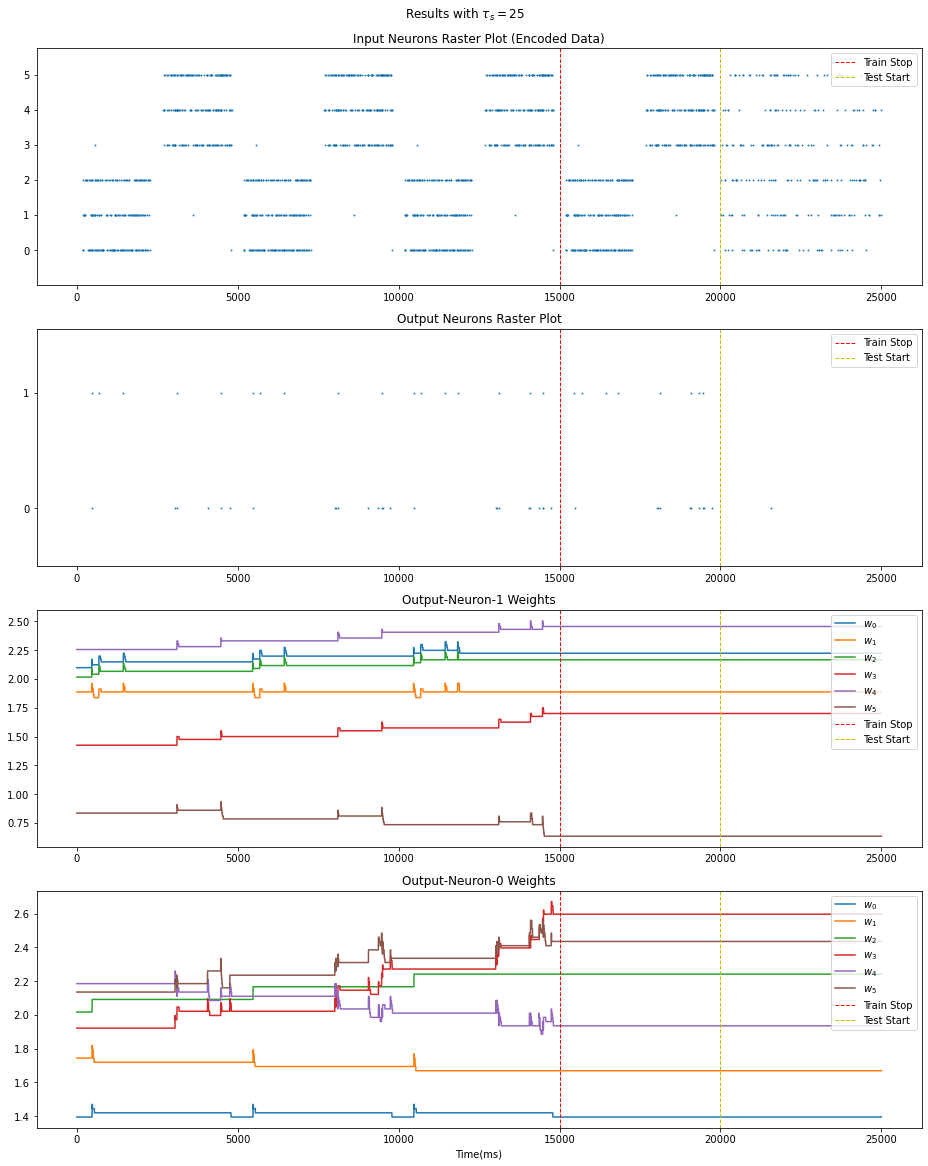

In [16]:
seed = 16372327855702577932
tau_s = [10, 17.5, 25]
for tau in tau_s:
    run_stdp(tau_s=tau, fig_title=rf"Results with $\tau_s = {tau}$",
             random_seed=seed, is_flat=True, lr=[0.025, 0.075])

By increasing the value of $\tau_s$, the network's ability to learn properly is
declining because older spikes are taken into account for updating the weights.
These old spikes contain un-wanted spikes and have a bad impact on the update rule.

# Some Random Simulations

The following simulations are presented to show the output of Flat-STDP without
manually selecting the random seeds resulting in favorable results.

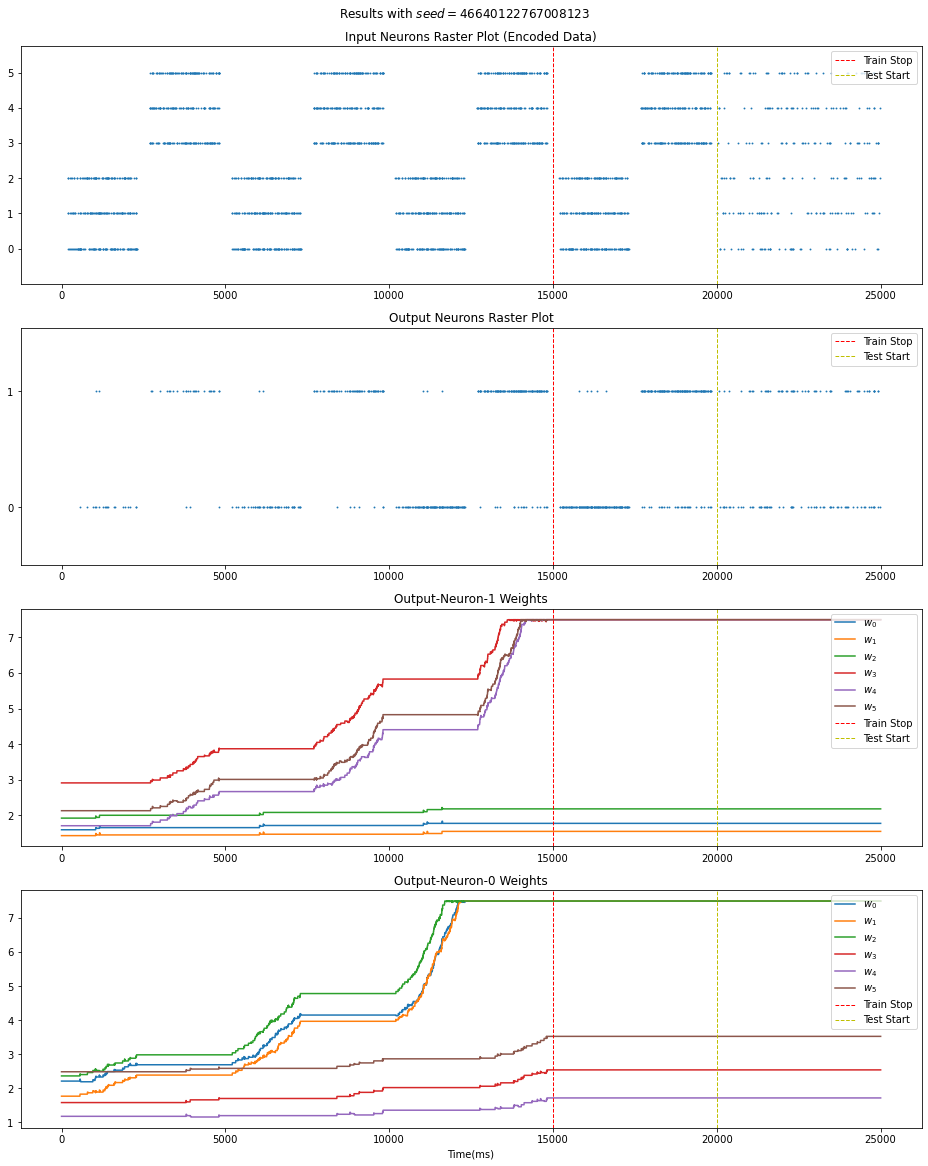

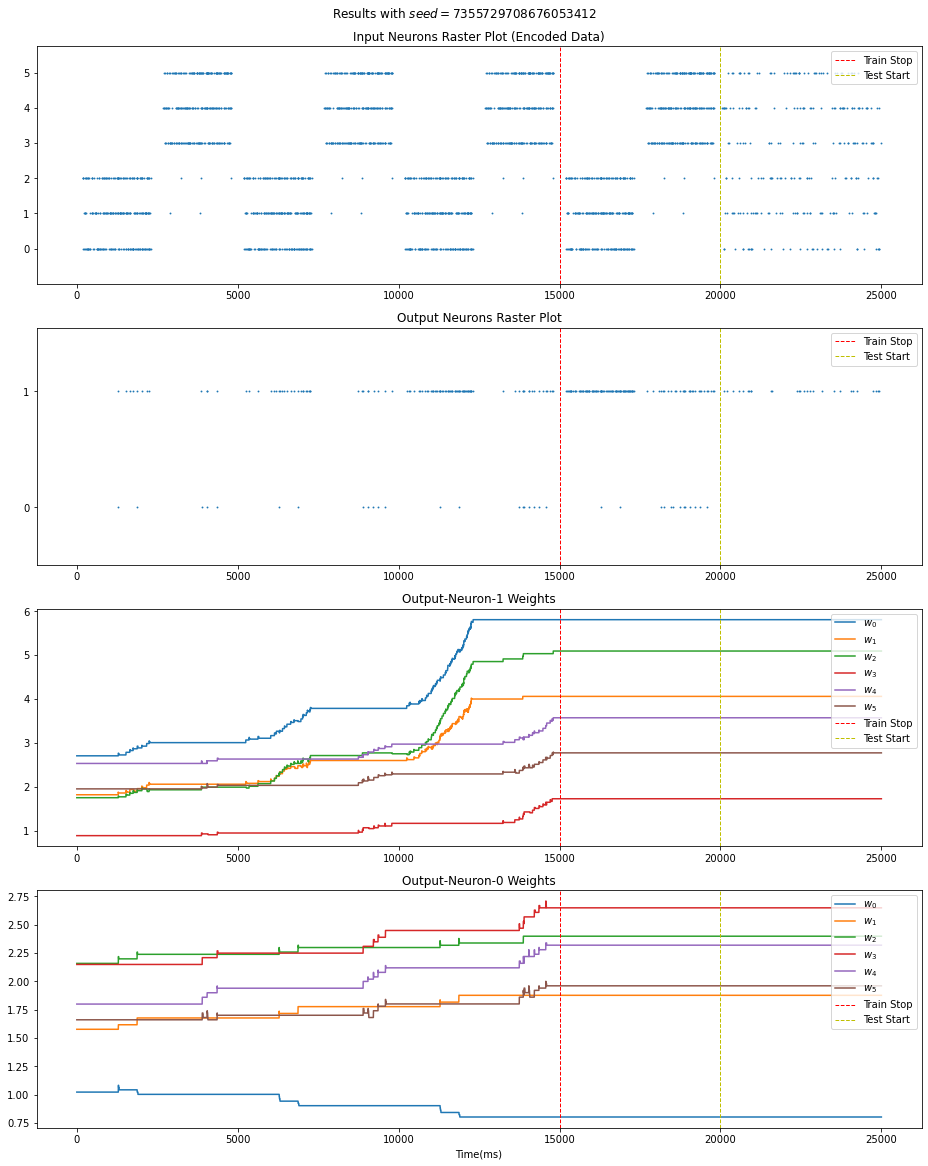

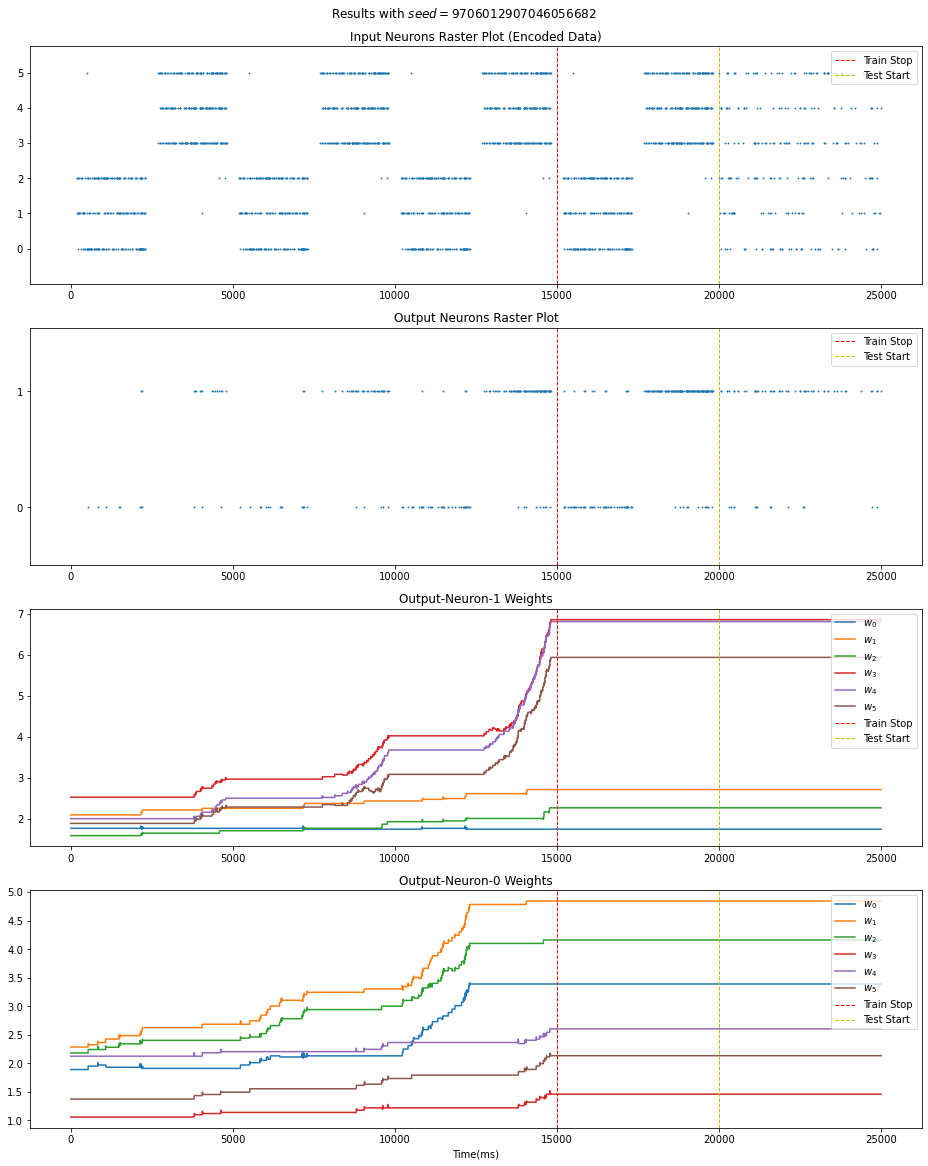

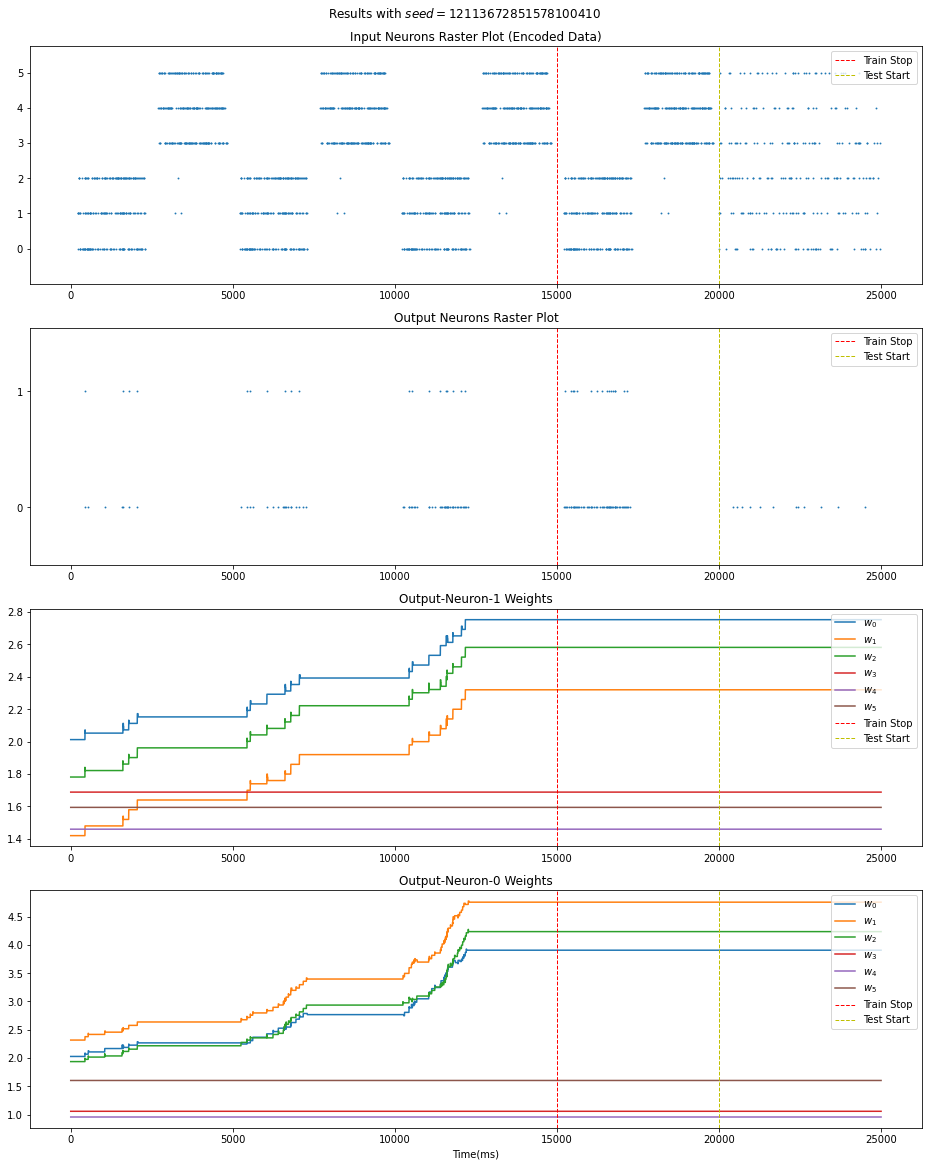

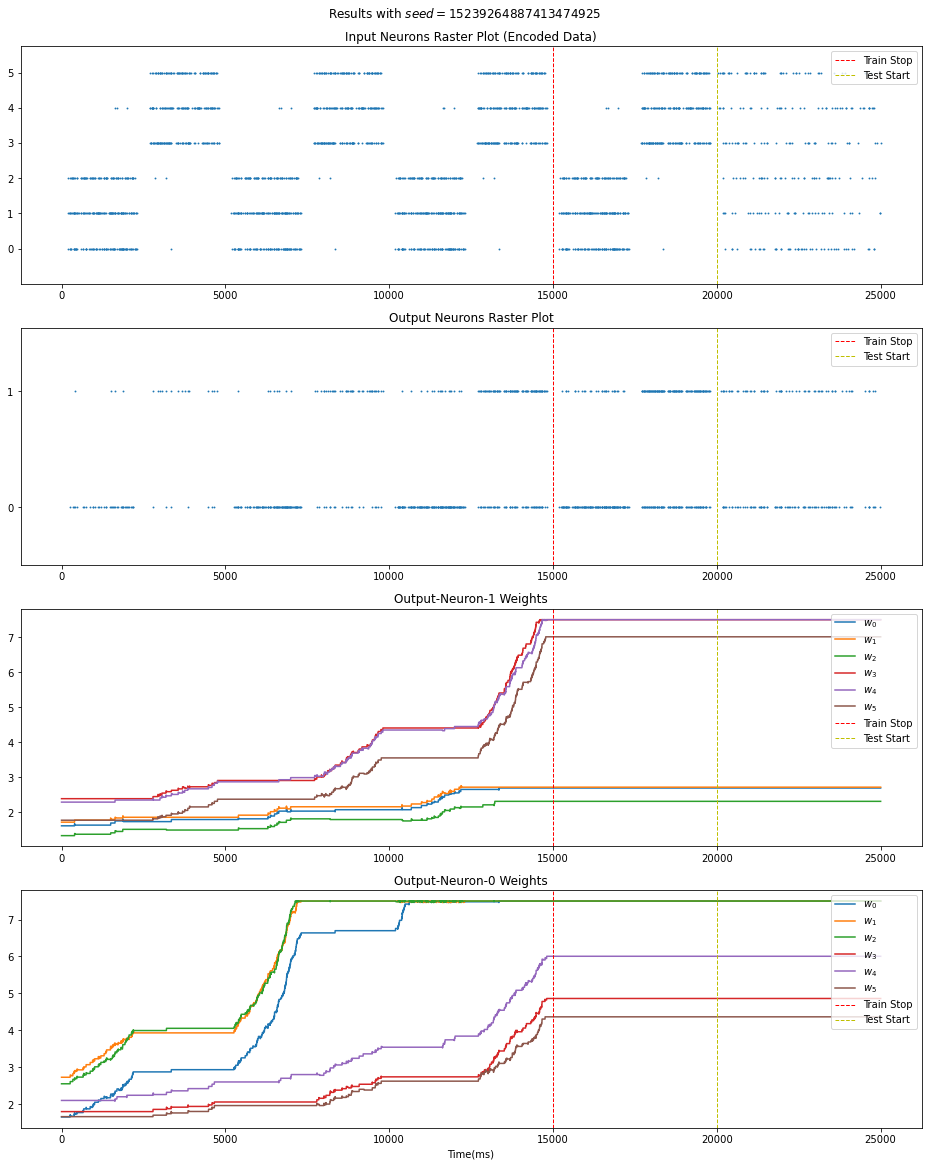

In [17]:
seeds = []
for i in range(5):
    seed = torch.random.seed()
    run_stdp(fig_title=rf"Results with $seed = {seed}$",
             random_seed=seed, is_flat=True, lr=[0.02, 0.05])
    seeds.append(seed)

# Summary

1. We can achieve almost the same results using `Flat-STDP` and `STDP`. So, it's better
to use `Flat-STDP` because it is simpler.

2. If the initial weights are too high, the network's initial activation is high;
therefore, the weights tend to saturate at the maximum value faster. Also, the network
sensibility only to the input patterns decreases, and the output neurons will
be activated frequently even with unseen data. In contrast, if the initial weights
are set too small, they cannot be activated using the input, and the learning will
not happen altogether.

3. It is better to keep $A_-$ a little higher than $A_+$ in `STDP`. The opposite is
true in `Flat-STDP`. By increasing both of these parameters, the learning will take
place faster.

4. It is better to keep $\tau_s$ small. High values for this parameter have a bad
impact on the learning process, because unwanted and old spikes will affect the update terms.
However, very low values also, might prevent the training to begin or make it too slow.

5. `STDP` is highly dependent on the initial weights and in many cases the output is not
what we expect from it. Sometimes both neurons learn the same input, sometimes
none of them learn anything, and sometimes one learns both patterns, and the other only
learns one of them or neither of them. The expected output (each neuron learns only
of the patterns) could be achieved by running the simulation multiple times and saving
the random-seed of initializations. One thing that will help to achieve these
favorable results more often is to add `lateral-inhibition` between output neurons.
We used this technique in this project. Another method is to use `homostatis`, which
we did not implement here.
